Introduction
================
-	https://ml-cheatsheet.readthedocs.io/en/latest/logistic_regression.html
-	LR a classification algorithm, that is commonly used where the response variable is binary – such as whether an email entering your inbox is spam or not, whether a bank transaction is fraudulent or not, or, in our case whether or not someone will get CHD within 10 years.  
-	In order to map predicted values to probabilities with LR, we use the sigmoid function. This function maps any value to a predicted probability.
-	Maths: P(class=1) = S(z)=1/(1+e^-z) with S(z) being the probability estimate and z is the linear fitting function to be optimised by the computer in the form z = W0 + W1x1 + W2x2 (+ …. + WNxN ). This is called ‘training’ the algorithm – creating a fit based on our dataset.

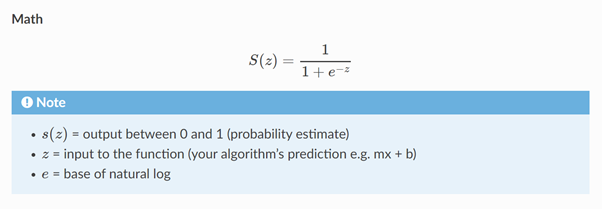



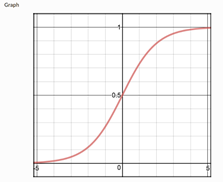

- To optimise this input function the we define a cost function called the cross entropy which is what the ML will aim to reduce to a minimum. This cost function is related to the (log of the) absolute distance from a point to the fitting function in multidimensional space and hence fits a regressive line to the training data – the regressive part of logistic regression. This is similar to fitting a linear regressor to a 2d function, the optimal fit can be found by varying the slope and intercept of a line until the distance between all points and the line is at a minimum (Mean square error).
- To minimise this cost function, the machine used a method called gradient descent (see gif where error is equivalent to the cost function). (Starting at the top of the mountain, we take our first step downhill in the direction specified by the negative gradient. Next we recalculate the negative gradient (passing in the coordinates of our new point) and take another step in the direction it specifies. We continue this process iteratively until we get to the bottom of our graph, or to a point where we can no longer move downhill–a local minimum where the function is fit.) https://ml-cheatsheet.readthedocs.io/en/latest/gradient_descent.html. 
- The final step is to calculate the probabilities based on the logit function and then to map these probabilities to classed by choosing a cut-off point, know as a Decision Boundary. For example, we may define any change greater than 20% as 1, for ‘likely’ to get CHD and any chance lower than 20% to be unlikely.



In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import preprocessing_ml as pp

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr" # "all"
%config InlineBackend.figure_format ='retina'
%matplotlib inline

#This is required to accept any changes to the module by forcing notebook to re-read the file 
#if any changes are made to the module while notebook is running
%load_ext autoreload
%autoreload 2


# import warnings filter
import warnings
# ignore all future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.exceptions import DataConversionWarning,UndefinedMetricWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)

# Set some plotting params
SMALL_SIZE = 10
MEDIUM_SIZE = 12
LARGE_SIZE = 15

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)  # fontsize of the figure title


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Algorithms to Optimise
-----------------

In [2]:
def log_regressor(X_train, y_train,r_state=0, v =0):
    '''Do linear regression fitting and print information about the success of the fitting
    - X_train: Dataframe x training set
    - y_train: Dataframe y training set
    - v (optional): boolean verbose
    - r_state (optional): random seed for logistic regression
    '''
    from sklearn.linear_model import LogisticRegression
    
    LR = LogisticRegression(random_state=r_state)
    LR = LR.fit(X_train, y_train) 
    
    if v == 1:
        print('Calculating logistic regressor......')
    
    return LR
    


In [3]:
def k_neighbors(X_train, y_train, v=0,  n_neighbors= 16):
    '''Do k_neighbors  fitting and print information about the success of the fitting
    - X_train: Dataframe x training set
    - y_train: Dataframe y training set
    - v (optional, default = 0): int (0 or 1) verbose
    - n_neighbors = 16: define number of neighbors 
    '''
    from sklearn.neighbors import KNeighborsClassifier
    
    KN = KNeighborsClassifier(n_neighbors=n_neighbors)
    KN.fit(X_train, y_train) 
    
    if v == 1:
        print('Calculating k-neighbours......')
        
    return KN



In [4]:
def support_vector_m(X_train, y_train, r_state=0,v=0,class_weight='balanced'):
    '''Do support vector mechanism fitting and print information about the success of the fitting
    - X_train: Dataframe x training set
    - y_train: Dataframe y training set
    - v (optional, default = 0): int (0 or 1) verbose
    '''
    from sklearn.svm import SVC
    
    if v == 1:
        print('\nCalculating Support vector machine ..\n')
        
    SVM = SVC(C=1, kernel='linear', class_weight=class_weight, probability=True, random_state=r_state) # penalize,
    SVM.fit(X_train, y_train) 
    
    return SVM

Measures of success
---------------

In [5]:
def cross_val(model, X, Y, scoring = ['accuracy','precision','recall','f1'], cv=5):
   #See https://scikit-learn.org/stable/modules/model_evaluation.html for list of allowed scoring params 
    from sklearn.model_selection import cross_val_score 
    
    print('\nCrossvalidation score for {} splits:\n'.format(cv))   
    
    cv_results = pd.DataFrame(columns=scoring)
    for measure in scoring:
        cv_results[measure] = cross_val_score(model, X, Y, scoring = measure, cv=cv)
    
    #print("Cross validation Accuracy:\n", cv_results.mean(),"\nCross validation STDEV:\n" , cv_results.std())
    return cv_results.mean()

def performance(model,X_test,y_test,cutoff=0.5,v=0,output='Accuracy'):
    from sklearn.preprocessing import binarize
    from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, classification_report

    if model == 'fram': # cheap and dirty fix for framingham data needing different processing
        y_pred = X_test > cutoff*100 
    else:
        y_pred = model.predict_proba(X_test)
        y_pred = binarize(y_pred,cutoff)[:,1]
    
    if v == 1: 
        print('\n========\nCuttoff: ',cutoff)
        print('Confusion Matrix:')
        cm=confusion_matrix(y_test,y_pred)
        conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
        print(confusion_matrix(y_test,y_pred))
    
        print('Accuracy: {:.2f}%'.format(accuracy_score(y_test,y_pred)*100))
        print('f1 score: {:.2f}%'.format(f1_score(y_test,y_pred)*100))
        print('precision score: {:.2f}%'.format(precision_score(y_test,y_pred)*100))
        print('recall score: {:.2f}%'.format(recall_score(y_test,y_pred)*100))
        
        print(classification_report(y_test,y_pred))
    

    if output == 'Accuracy':
         return accuracy_score(y_test,y_pred)
    elif output == 'Precision':
         return precision_score(y_test,y_pred)
    elif output == 'Recall':
         return recall_score(y_test,y_pred)
    elif output == 'f1_score':
         return f1_score(y_test,y_pred)
    elif output == 'All':
        a = [accuracy_score(y_test,y_pred), precision_score(y_test,y_pred),
                      recall_score(y_test,y_pred), f1_score(y_test,y_pred)]
        return a



    
# measure = cross_val(k_neighbors(X_train, X_test, y_train, y_test), X_train, y_train,scoring=['accuracy'])

# measure
#where model_name is replaced by whatever you have defined the model fit as 
#For example in the K-neighbors section I have defined the model_name as KN. (see k_neighbors function)

Optimising
---------------

In [6]:
#Read in from pre-determined csv of framingham percentages and whether the patient actually got CHD.
df_fram = pd.read_csv("Framingham Score/fram_risk.csv",index_col="index")[['TenYearCHD','fram_percent']]
df_fram.head()


,TenYearCHD,fram_percent
index,,
0,0,0.905684
1,0,1.004992
2,0,16.647594
3,1,8.771542
4,0,8.621980


In [7]:
dataset = pd.read_csv('framingham.csv')

from statsmodels.tools import add_constant as add_constant
dataset_c = add_constant(dataset)
dataset_c.head()

# print(pp.chose_features(dataset_c, features=['TenYearCHD', 'const', 'sysBP', 'glucose' ,'age', 'totChol', ]))
# from imblearn.over_sampling import SMOTE

,const,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1.0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,1.0,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1.0,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,1.0,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,1.0,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [8]:
def t_features(dataset, f_algorithm, remove_missing='drop', scale = True, resample = 'none', 
               cutoff=0.5, metrics=['Accuracy','Precision','Recall','f1_score'], label='', v = 0):
    '''Investigate the effects n_features on a graph. Allows flexible graphing to investigate many variables.
    - dataset: DataFrame. The dataset to analyse.
    - f_algorithm: function pointer. A function that fits X_train and y_train
    - *remove_missing: How preprocessing should remove missing values. Options are:
                        - 'drop': uses preprocessing_ml.drop_missing to remove missing values, 
                        - 'impute_median': uses preprocessing_ml.impute_missing(strategy='median')
                        - 'impute_mean' which uses preprocessing_ml.impute_missing(strategy='mean')
    - *scale: Whether to scale data in preprocessing. If true uses preprocessing_ml.scale_data(). 
    - *resample: Whether to resample data. Options are:
                        - 'none': no resampling, 
                        - 'up': uses preprocessing_ml.upsample()
                        - 'down' which uses preprocessing_ml.downsample()
    - *cutoff: float in range(0,1). Cutoff by which a positive/negative result is predicted.
    - *metrics: list of strings from 'Accuracy','Precision','Recall','f1_score'. Score which to return
    - *label: string to append to legend entry
    - *v: 1 or 0, verbose
    '''
    
    features = ['TenYearCHD','const','sysBP', 'glucose', 'age', 'totChol', 'cigsPerDay', 'diaBP', 'prevalentHyp',
                'diabetes', 'BPMeds', 'male', 'BMI',
                'education', 'heartRate'] 

    #Investigate effect of no. features
    results_logreg = [] #Store results
    MIN_FEATURES = 3 #Min number of features to learn from
    for i in range(MIN_FEATURES,len(features)+1):
        
        dataset2 = pp.chose_features(dataset, features=features[:i]) # choose top n features
        
        # preprocess to remove missing values....
        if remove_missing == 'drop':
            dataset2 = pp.drop_missing(dataset2) # by dropping missing rows            
        elif remove_missing == 'impute_mean':
            dataset2 = pp.impute_missing(dataset2,strategy='mean') # by imputing missing rows with mean
        elif remove_missing == 'impute_median':
            dataset2 = pp.impute_missing(dataset2,strategy='median') # by imputing missing rows with median
        else:
            print('[ERROR] t_features: arg* remove_missing must be one of "drop", "impute_mean" or "impute_median"')
            return(-1)
        
        if scale == True: # preprocess to scale data
            dataset2 = pp.scale_data(dataset2)
        

        # preprocess resampling training set
        if resample == 'none':
            X_train, X_test, y_train, y_test = pp.split_data(dataset2) # split dataset 
        elif resample == 'up':
            train, test = pp.split_data(dataset2,split_dep_var=False)
            train = pp.upsample(train,v=0)
            X_train, y_train = pp.split_dep_var(train); X_test, y_test = pp.split_dep_var(test)
        elif resample == 'down':
            train, test = pp.split_data(dataset2,split_dep_var=False)
            train = pp.downsample(train,v=0)
            X_train, y_train = pp.split_dep_var(train); X_test, y_test = pp.split_dep_var(test)
        else:
            print('[ERROR] t_features: arg* resample must be one of "none", "up" or "down"')
            return(-1)

        algor = f_algorithm(X_train,y_train) # run ML fitting to training set

        results_logreg.append(performance(algor,X_test,y_test,output= 'All')) # append performance measure(s)


    results_logreg = pd.DataFrame(results_logreg,columns=['Accuracy','Precision','Recall','f1_score']) # create dataframe 
    results_logreg = results_logreg[metrics] # drop columns not selected by user

    for metric in results_logreg.columns: # plot metrics and print max vals
        plt.plot(range(3,i+1), results_logreg[metric],label="{} {}".format(metric,label),marker='o')
        if v == 1:
            print(metric, "max={:.4f} at N_features = {}".format(max(results_logreg[metric]),
                                                                 results_logreg[metric].idxmax()+MIN_FEATURES))
    if v == 1:
        print('')

    #basic graph formatting
    plt.grid(True)
    plt.xlabel('Number of features')
    plt.ylabel('Score')
    plt.legend(bbox_to_anchor=(1, 0.9))



In [61]:
def t_cutoff(dataset, f_algorithm, remove_outliers = False, remove_missing='drop', scale = None, resample = 'none', 
               n_features=len(dataset.columns),metrics=['Accuracy','Precision','Recall','f1_score'], 
                 label='',x_max=0.5, v = 0, op= 'f1_score'):
    '''Investigate the effects cutoff on a graph. Allows flexible graphing to investigate many variables.
    - dataset: DataFrame. The dataset to analyse.
    - f_algorithm: function pointer. A function that fits X_train and y_train
    - *remove_outliers: Whether or not to remove outliers. True or False
    - *remove_missing: How preprocessing should remove missing values. Options are:
                        - 'drop': uses preprocessing_ml.drop_missing to remove missing values, 
                        - 'impute_median': uses preprocessing_ml.impute_missing(strategy='median')
                        - 'impute_mean' which uses preprocessing_ml.impute_missing(strategy='mean')
    - *scale: Whether to scale data in preprocessing. If true uses preprocessing_ml.scale_data(). 
                        - 'standard': standard scalar, 
                        - 'minmax': mimax scalar
    - *resample: Whether to resample data. Options are:
                        - 'none': no resampling, 
                        - 'smote': resample with smote function, 
                        - 'up': uses preprocessing_ml.upsample()
                        - 'down' which uses preprocessing_ml.downsample()
    - *n_features: int in range(1,16). How many features to use (default is all features).
    - *metrics: list of strings from 'Accuracy','Precision','Recall','f1_score'. Score which to return
    - *label: string to append to legend entry
    - *x_max: max cutoff to test up to
    - *v: 1 or 0, verbose. If 1, print optimised cutoff based on value of the optimisation parameter op
    - *op: optimisation parameter. Print optimised value and metric. Choose from 'Accuracy','Precision','Recall','f1_score'
    '''
    
    N_POINTS = 100 # Precision / number of cutoff points to plot - affects runtime
    RANGE_X = np.arange(0, x_max, x_max/N_POINTS) # range of cutoffs to test

    features = ['TenYearCHD','const','sysBP', 'glucose', 'age', 'totChol', 'cigsPerDay', 'diaBP', 'prevalentHyp',
                'diabetes', 'BPMeds', 'male', 'BMI',
                'education', 'heartRate'] 

    dataset_t = pp.chose_features(dataset, features=features[:n_features]) # choose n features
    if remove_outliers == True:
        dataset_t = pp.outliers(dataset_t,v=v)
    
    # preprocess to remove missing values....
    if remove_missing == 'drop':
        dataset2 = pp.drop_missing(dataset_t,v=v) # by dropping missing rows            
    elif remove_missing == 'impute_mean':
        dataset2 = pp.impute_missing(dataset_t,strategy='mean',v=v) # by imputing missing rows with mean
    elif remove_missing == 'impute_median':
        dataset2 = pp.impute_missing(dataset_t,strategy='median',v=v) # by imputing missing rows with median
    else:
        print('[ERROR] t_features: arg* remove_missing must be one of "drop", "impute_mean" or "impute_median"')
        return(-1)
        
    if scale == 'standard': # preprocess to scale data
        dataset2 = pp.scale_data(dataset2, 'standard',v=v)
    elif scale == 'minmax': # preprocess to scale data
        dataset2 = pp.scale_data(dataset2, 'minmax',v=v)
        
    # preprocess resampling training set
    if resample == 'none':
        X_train, X_test, y_train, y_test = pp.split_data(dataset2,r_state=0,v=v) # split dataset 
    elif resample == 'smote':
        X_train, X_test, y_train, y_test =  pp.smote(dataset2,r_state=0,v=v) # split dataset 
    elif resample == 'up':
        train, test = pp.split_data(dataset2,split_dep_var=False,r_state=0)
        train = pp.upsample(train,ratio_1_to_0=0.6,v=v)
        X_train, y_train = pp.split_dep_var(train); X_test, y_test = pp.split_dep_var(test)
    elif resample == 'down':
        train, test = pp.split_data(dataset2,split_dep_var=False,r_state=0)
        train = pp.downsample(train,ratio_1_to_0=0.6,v=v)
        X_train, y_train = pp.split_dep_var(train); X_test, y_test = pp.split_dep_var(test)
    else:
        print('[ERROR] t_features: arg* resample must be one of "none", "smote", "up" or "down"')
        return(-1)

    ML = f_algorithm(X_train, y_train) # train ML

    for metric in metrics: # for each metric 
        results = []
        for cutoff in RANGE_X: # find cutoff performance
            results.append([cutoff,performance(ML,X_test,y_test,cutoff=cutoff,output=metric)])
        results = pd.DataFrame(results,columns=['cutoff','value'])
        #plot line
        line = plt.plot(results['cutoff'], results['value'],label="{} {}".format(metric,label),marker='o')
        
        # print the OPTIMUM cutoff and scores at that particular cutoff
        if v == 1: # verbose
            if metric == op: # Print optimal cutoff and scores at this cutoff for the chosen optimisation parameter (op)
                optimal_cut = results['cutoff'].iloc[results['value'].idxmax()]
                print("Optimising {}. Max at cutoff = {:.4f}".format(metric, optimal_cut))
                plt.axvline(x=optimal_cut,linewidth=2, color=line[-1].get_color(),linestyle='--')
                for metric_2 in ['Accuracy','Precision','Recall','f1_score']:
                    print("{} = {:.4f}".format(metric_2,performance(ML,X_test,y_test,cutoff=optimal_cut
                                                                                ,output=metric_2)))

#             [cutoff,performance(ML,X_test,y_test,cutoff=cutoff,output=metric)]

    if v == 1:
        print('') 
        
    #setting up formatting
    plt.grid(True)
    plt.xlabel('Cutoff')
    plt.xlim(RANGE_X.min(),RANGE_X.max())
    plt.ylabel('Performance')
    plt.legend()#bbox_to_anchor=(1, 0.9))

def t_cutoff_fram(df_fram, metrics=['Accuracy','Precision','Recall','f1_score'], label='', x_max=0.5, v = 0,
                  op = 'f1_score'):
    '''Investigate the effects cutoff on a graph for framingham algorithm
    - df_fram: DataFrame with prtedicted probabilities for 1 and 0 and TenYearCHD result
    - *metrics: list of strings from 'Accuracy','Precision','Recall','f1_score'. Scores to plot.
    - *label: string to append to legend entry
    - *x_max: max cutoff to test up to
    - *v: 1 or 0, verbose. If 1, print optimised cutoff based on value of the optimisation parameter op
    - *op: optimisation parameter. Print optimised value and metric. Choose from 'Accuracy','Precision','Recall','f1_score'
    '''
    N_POINTS = 100 # Precision / number of cutoff points to plot - affects runtime
    RANGE_X = np.arange(0, x_max, x_max/N_POINTS) # range of cutoffs to test

    for metric in metrics: # for each metric 
        results = []
        for cutoff in RANGE_X: # for each cutoff
            results.append([cutoff,performance('fram',df_fram['fram_percent'],df_fram['TenYearCHD'],cutoff=cutoff,
                                               output=metric)]) # calculate performance
            
        results = pd.DataFrame(results,columns=['cutoff','value'])
        #plot the results
        plt.plot(results['cutoff'], results['value'],label="{} {}".format(metric,label),marker='o')
        
        if v == 1: 
            if metric == op:  # Print optimal cutoff and scores at this cutoff for the chosen optimisation parameter (op)
                optimal_cut = results['cutoff'].iloc[results['value'].idxmax()]
                print("Optimising {}. Max at cutoff = {:.4f}".format(metric, optimal_cut))
                plt.axvline(x=optimal_cut,linewidth=1, color='k',linestyle='--')
                for metric_2 in ['Accuracy','Precision','Recall','f1_score']:
                    print("{} = {:.4f}".format(metric_2,performance('fram',df_fram['fram_percent'],df_fram['TenYearCHD'],
                                                                    cutoff=optimal_cut,output=metric_2)))
    plt.grid(True)
    plt.xlabel('Cutoff')
    plt.xlim(RANGE_X.min(),RANGE_X.max())
    plt.ylabel('Performance')
    plt.legend(bbox_to_anchor=(1, 0.9))



The following is the test cell for optimisation. Uncomment tests and try running them

 Logistic Regression 

Now dropping rows with missing values....
	 * Dropped 582 rows 13.7%. 3658 rows remaining


Splitting data set into training and test sets....
	 * 80.0% data in training set
	 * 20.0% data in test set
Optimising f1_score. Max at cutoff = 0.1782
Accuracy = 0.7445
Precision = 0.3655
Recall = 0.7073
f1_score = 0.4820

Now dropping rows with missing values....
	 * Dropped 582 rows 13.7%. 3658 rows remaining


Upsampling data using SMOTE
Splitting data set into training and test sets....
The ratio of train data to test data is 0.8:1

The original ratio of CHD to non-CHD was: 5.6: 1
The new ratio of CHD to non-CHD is: 1.0: 1
Optimising f1_score. Max at cutoff = 0.5148
Accuracy = 0.6872
Precision = 0.2314
Recall = 0.5657
f1_score = 0.3284

Now dropping rows with missing values....
	 * Dropped 582 rows 13.7%. 3658 rows remaining


Upsampling data....
Number values before resample:
 0    2492
1     434
Name: TenYearCHD, dtype: int64
Ratio before 1:0 = 0.17415730337078653


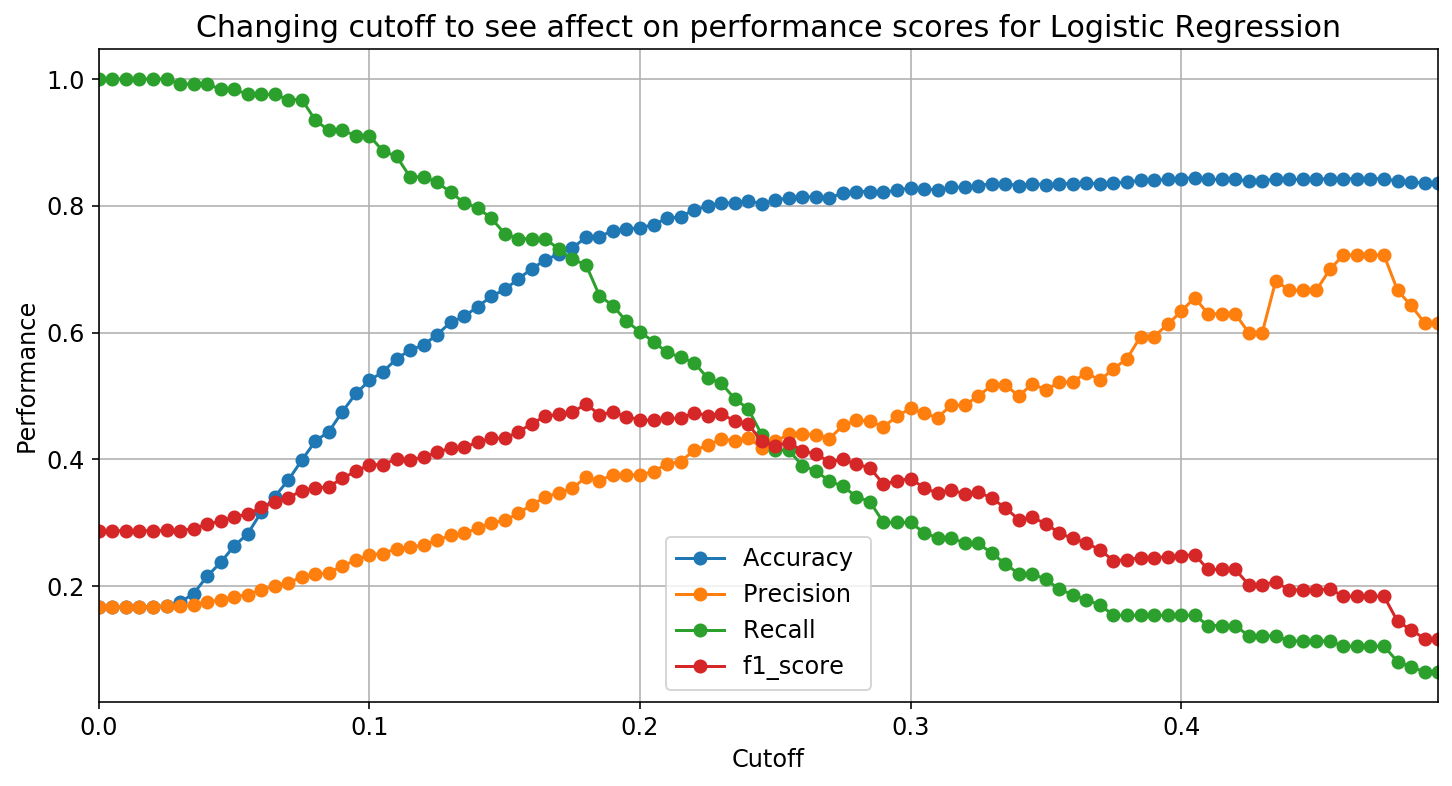

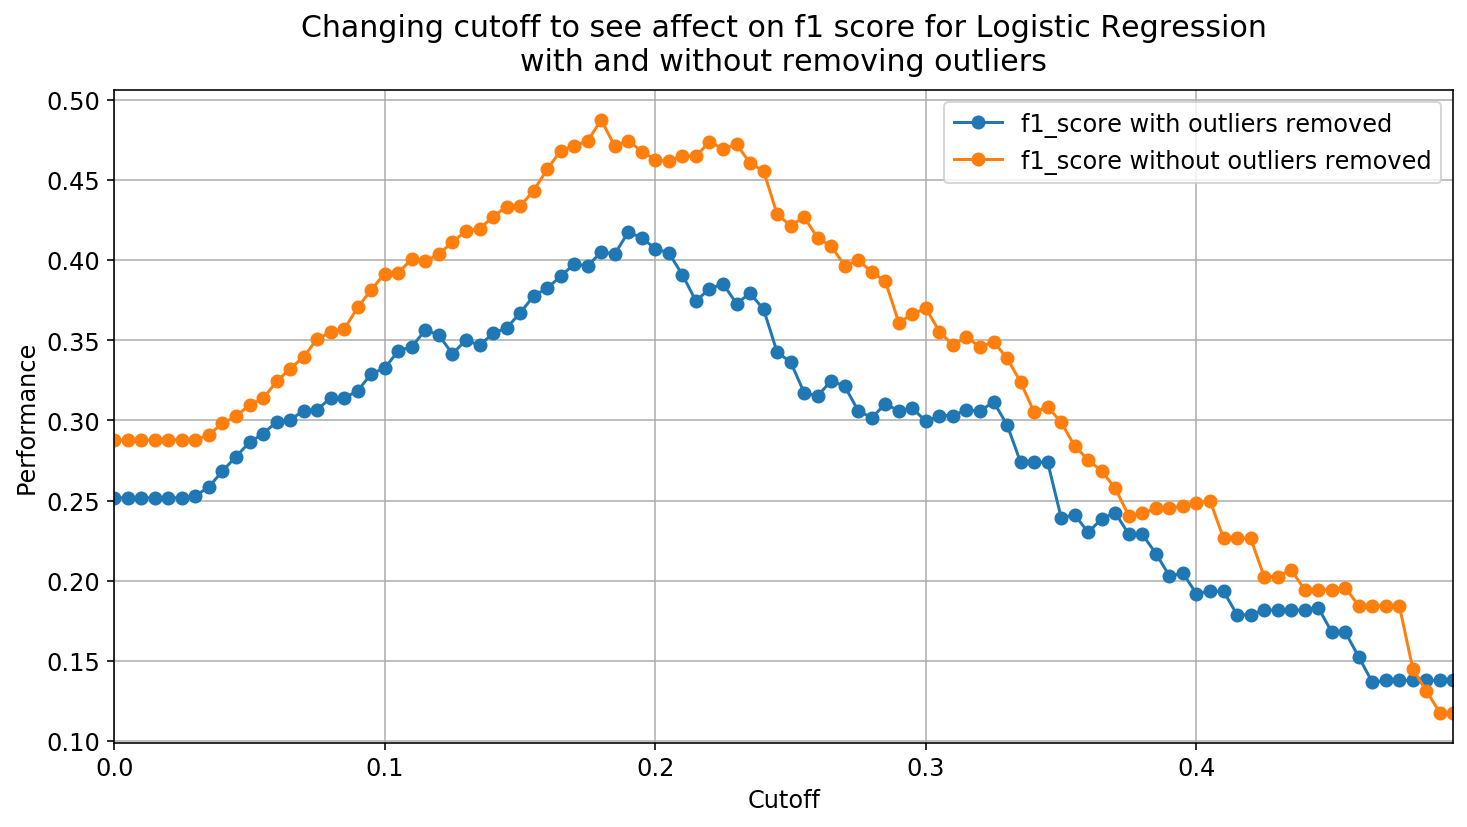

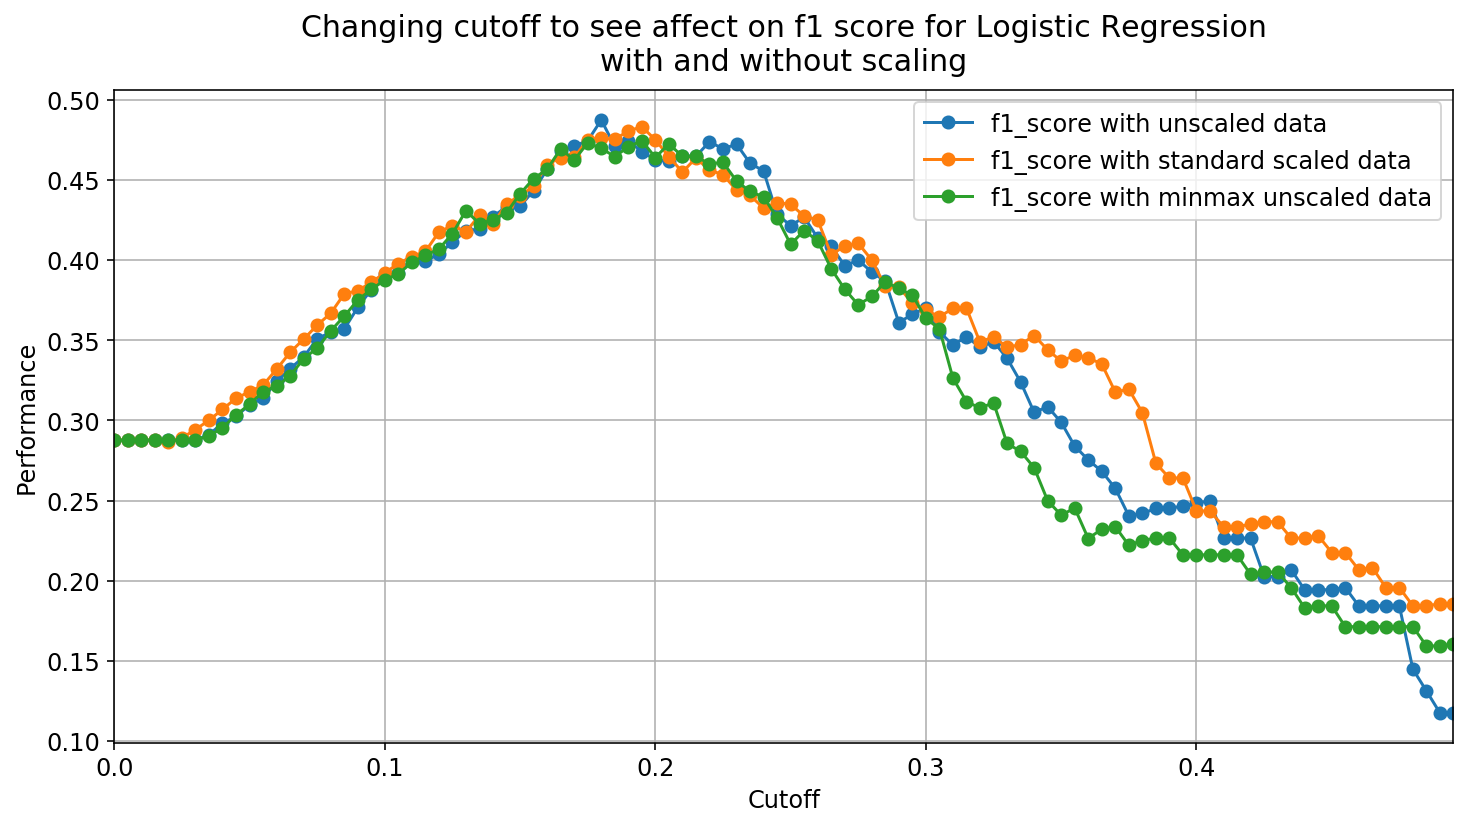

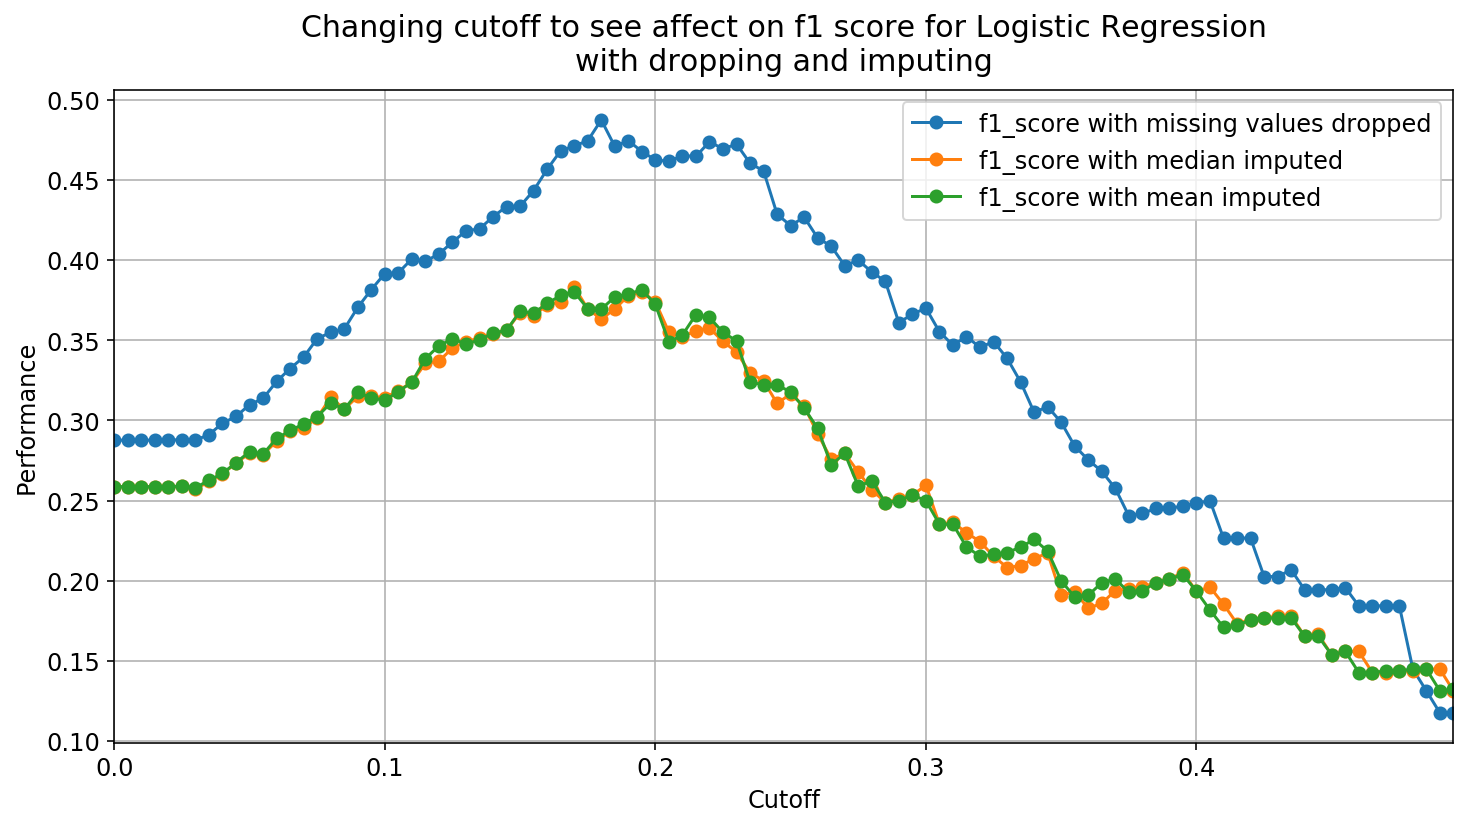

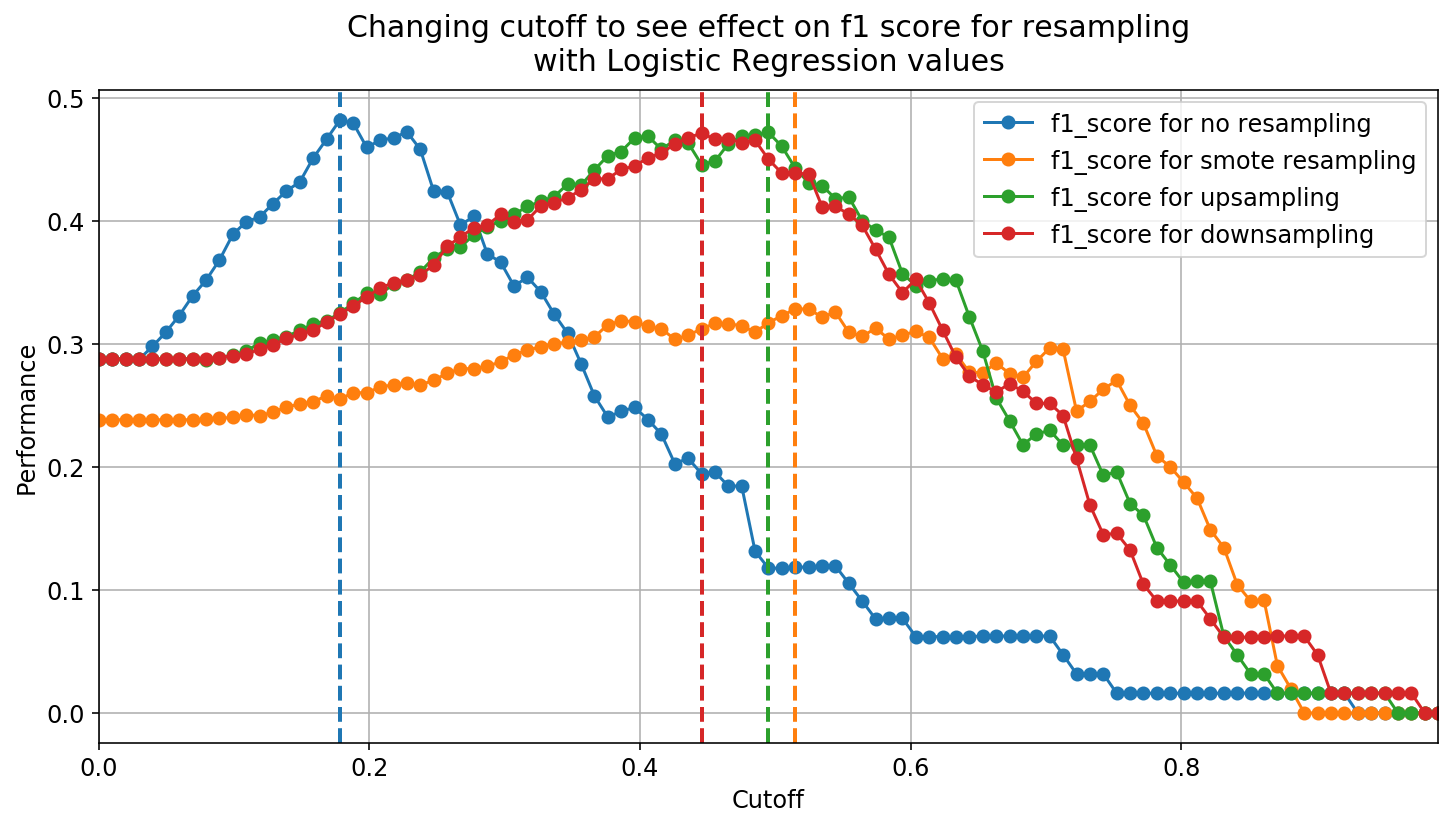

In [64]:
# Create a dictionary for the algorithms tested and run tests

algorithms = {
  "Logistic Regression": log_regressor,
  "K Neighbours": k_neighbors,
  "Support Vector Machine": support_vector_m
}

algorithms_to_test=["Logistic Regression"] # test specific algorithm(s)
# algorithms_to_test = algorithms.keys() # test all


for a in algorithms_to_test:
    print ("====================\n",a,"\n")
    
    ########################################
    ####    Plotting over n features    ####
    ########################################

#     plt.figure(figsize=(12, 6))
#     plt.title('Changing number of features to see affect on performance scores for {}'.format(a))
#     t_features(dataset_c,algorithms[a],metrics=['f1_score'])

#     plt.figure(figsize=(12, 6))
#     plt.title('Changing number of features to see affect on f1 score for {} with and without scaling'.format(a))
#     t_features(dataset_c,algorithms[a],scale=True, metrics=['f1_score'], label='with scaled data')
#     t_features(dataset_c,algorithms[a],scale=False, metrics=['f1_score'], label='with unscaled data')
    
#     plt.figure(figsize=(12, 6))
#     plt.title('Changing number of features to see affect on f1 score for {} with dropping and imputing'.format(a))
#     t_features(dataset_c,algorithms[a], remove_missing = 'drop', metrics=['f1_score'], label='with missing values dropped')
#     t_features(dataset_c,algorithms[a], remove_missing = 'impute_median', metrics=['f1_score'], label='with median imputed')
#     t_features(dataset_c,algorithms[a], remove_missing = 'impute_mean', metrics=['f1_score'], label='with mean imputed')

#     plt.figure(figsize=(12, 6))
#     plt.title('Changing number of features to see effect on f1 score for resampling with {}'.format(a))
#     t_features(dataset_c, algorithms[a], resample = 'down',metrics=['f1_score'],label='for upsampling')
#     t_features(dataset_c, algorithms[a], resample = 'up',metrics=['f1_score'],label='for downsampling')
#     t_features(dataset_c, algorithms[a], resample = 'none',metrics=['f1_score'],label='for no resampling')

    ########################################
    ####    Plotting over thresholds    ####
    ########################################

    plt.figure(figsize=(12, 6))
    plt.title('Changing cutoff to see affect on performance scores for {}'.format(a),fontsize=15)
    t_cutoff(dataset_c,algorithms[a])
    
    plt.figure(figsize=(12, 6))
    plt.title('Changing cutoff to see affect on f1 score for {}\nwith and without removing outliers'.format(a),fontsize=15,pad=10)
    t_cutoff(dataset_c,algorithms[a],remove_outliers=True, metrics=['f1_score'], label='with outliers removed')
    t_cutoff(dataset_c,algorithms[a],remove_outliers=False, metrics=['f1_score'], label='without outliers removed')

    plt.figure(figsize=(12, 6))
    plt.title('Changing cutoff to see affect on f1 score for {}\nwith and without scaling'.format(a),fontsize=15,pad=10)
    t_cutoff(dataset_c,algorithms[a],scale='none', metrics=['f1_score'], label='with unscaled data')
    t_cutoff(dataset_c,algorithms[a],scale='standard', metrics=['f1_score'], label='with standard scaled data')
    t_cutoff(dataset_c,algorithms[a],scale='minmax', metrics=['f1_score'], label='with minmax unscaled data')

    plt.figure(figsize=(12, 6))
    plt.title('Changing cutoff to see affect on f1 score for {}\nwith dropping and imputing'.format(a),fontsize=15,pad=10)
    t_cutoff(dataset_c,algorithms[a], remove_missing = 'drop', metrics=['f1_score'], label='with missing values dropped')
    t_cutoff(dataset_c,algorithms[a], remove_missing = 'impute_median', metrics=['f1_score'], label='with median imputed')
    t_cutoff(dataset_c,algorithms[a], remove_missing = 'impute_mean', metrics=['f1_score'], label='with mean imputed')

    plt.figure(figsize=(12, 6))
    plt.title('Changing cutoff to see effect on f1 score for resampling\nwith {} values'.format(a),fontsize=15,pad=10)
    t_cutoff(dataset_c, algorithms[a], resample = 'none',metrics=['f1_score'],label='for no resampling',x_max=0.99,v=1)
    t_cutoff(dataset_c, algorithms[a], resample = 'smote',metrics=['f1_score'],label='for smote resampling',x_max=0.99,v=1)
    t_cutoff(dataset_c, algorithms[a], resample = 'up',metrics=['f1_score'],label='for upsampling',x_max=0.99,v=1)
    t_cutoff(dataset_c, algorithms[a], resample = 'down',metrics=['f1_score'],label='for downsampling',x_max=0.99,v=1)
    



Now dropping rows with missing values....
	 * Dropped 582 rows 13.7%. 3658 rows remaining

Scaling data....
	 * Using standard scaling

Splitting data set into training and test sets....
	 * 80.0% data in training set
	 * 20.0% data in test set
Optimising f1_score. Max at cutoff = 0.1920
Accuracy = 0.7664
Precision = 0.3846
Recall = 0.6504
f1_score = 0.4834

Optimising f1_score. Max at cutoff = 0.0800
Accuracy = 0.6506
Precision = 0.2445
Recall = 0.6194
f1_score = 0.3506


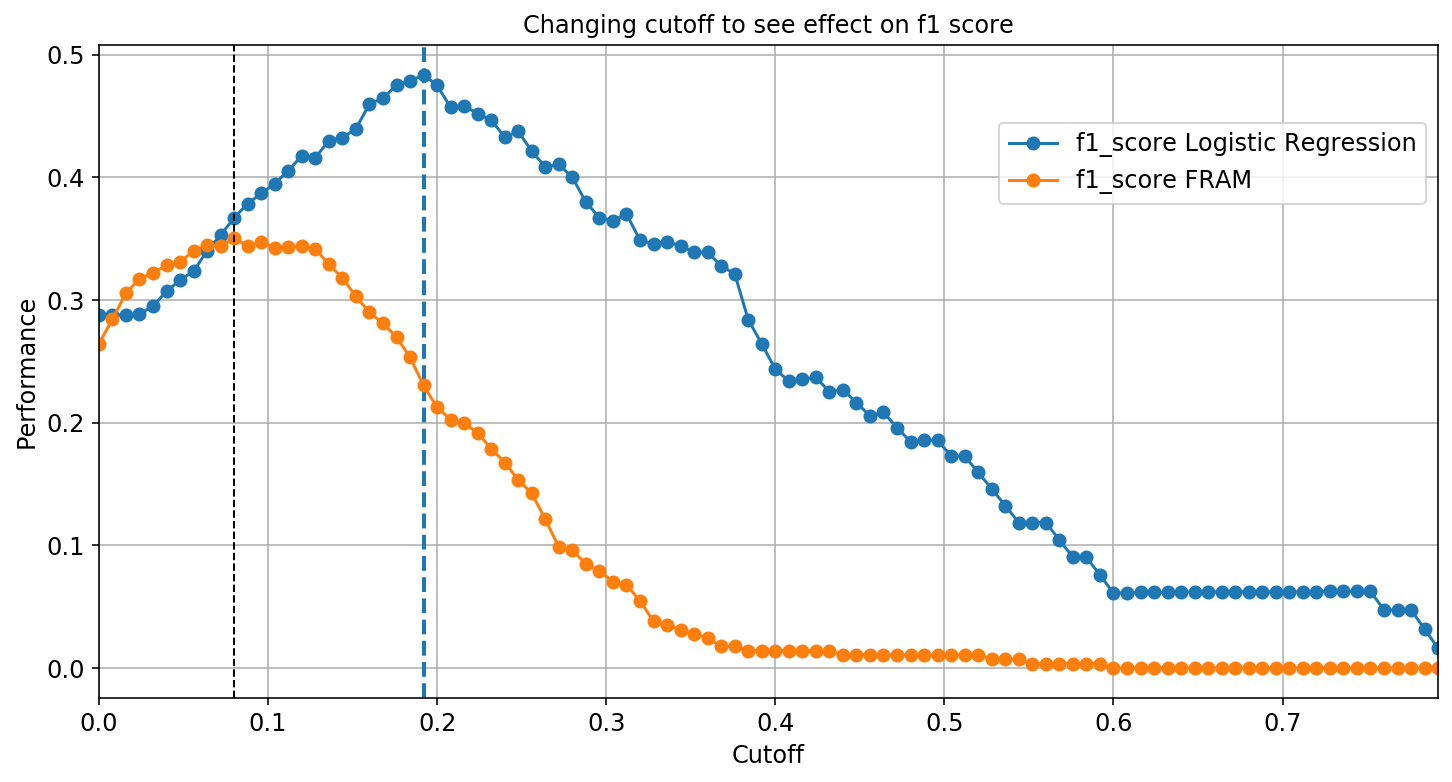

In [75]:
t_algorithm = "Logistic Regression"

plt.figure(figsize=(12, 6))
plt.title('Changing cutoff to see effect on f1 score'.format(a))
t_cutoff(dataset_c, algorithms[t_algorithm], remove_outliers=False, scale='standard', remove_missing = 'drop',
         resample = 'none', metrics=['f1_score'],x_max=0.8,v=1,op='f1_score',label=t_algorithm)

t_cutoff_fram(df_fram,metrics=['f1_score'],label='FRAM',x_max=0.8,v=1,op='f1_score')

# print(performance('fram',df_fram['fram_percent'],df_fram['TenYearCHD'],
#                                                                 cutoff=0.0800,output = 'All',v=1))


In [67]:
#histogram of freq of each % chance predicted by model. Shows the distribution of what the model predicts.

def t_plot_hist(y_pred,label,n_bins=20,fit=None):
    '''Plot distribution of a set of probabilities.
    - dataset: y_pred. List of predicted %.
    - *n_bins: number of bins in histogram
    - *fit: Apply a distribution fit to data. Options are 'norm' for normal dist, 'skew' for skewed normal 
                                                or 'exp' for exponential fit
    '''
    from scipy.stats import norm, expon, skewnorm
    
    n, bins, patches = plt.hist(y_pred, bins = n_bins,alpha=0.5,label=label,density=1)
    
    if fit == 'norm':
        mu, sigma = norm.fit(y_pred)
        plt.plot(bins, norm.pdf(bins, mu, sigma), 'r--', linewidth=2, label='normal fit')
        plt.axvline(x=mu,linewidth=1, color='k',linestyle='--',label=r'$\sigma = {}$'.format(round(mu,3))) #adds thick red line @ y=0
    
    if fit == 'exp':
        plt.plot(bins, expon.pdf(bins, *expon.fit(y_pred)), 'r--', linewidth=2, label='exp fit')
    
    if fit == 'skew':
        plt.plot(bins, skewnorm.pdf(bins, *skewnorm.fit(y_pred)), 'r--', linewidth=2, label='skewnorm fit')

    plt.xlabel('CHD %')
    plt.ylabel('Freq Density')
    plt.xlim(left=0.0, right=1)
    plt.legend()


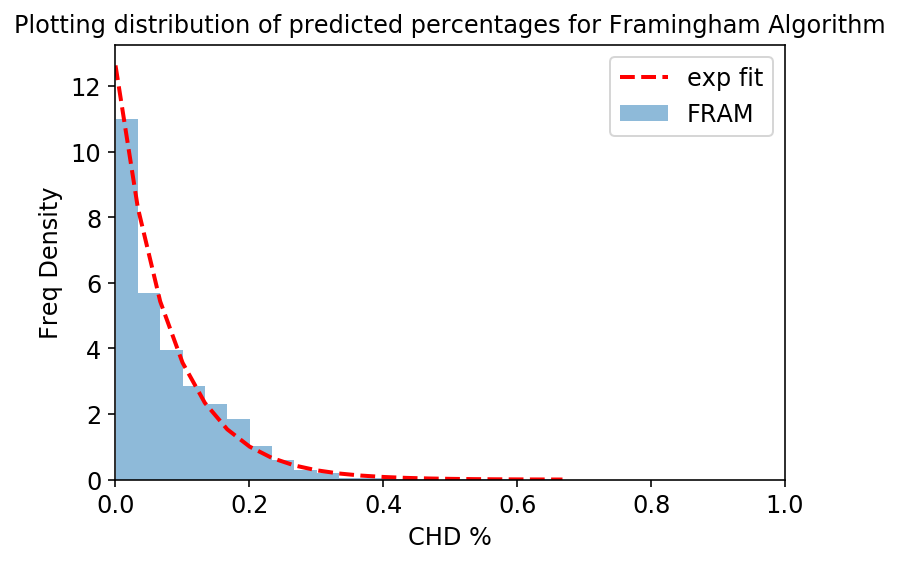

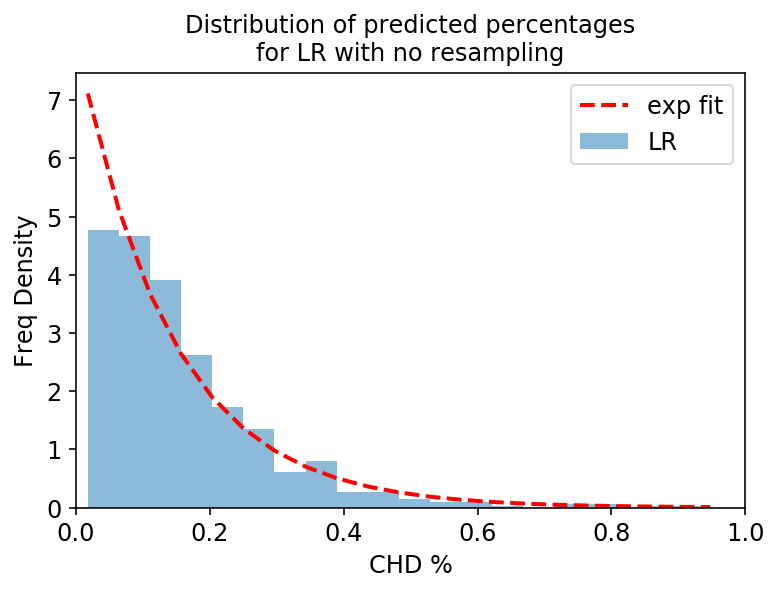

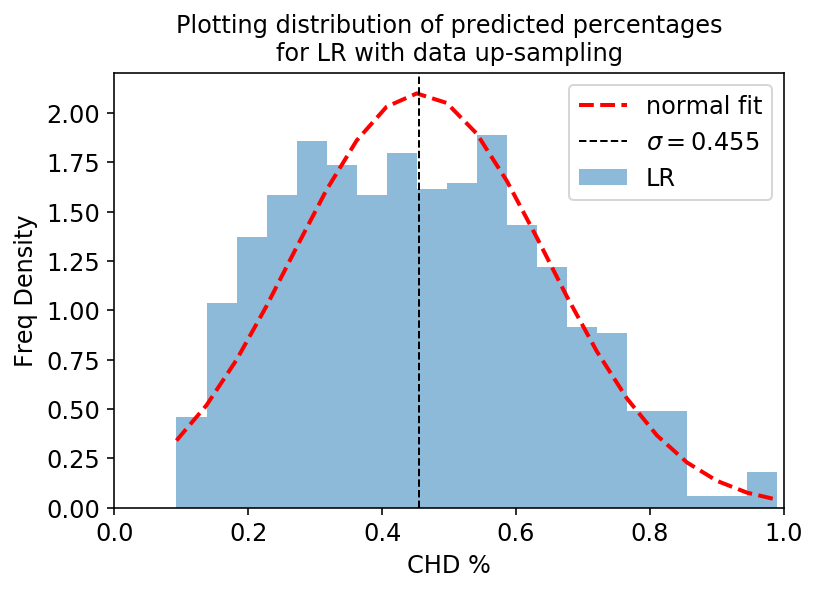

In [72]:
########################## Test conditions
features = ['TenYearCHD','const','sysBP', 'glucose', 'age', 'totChol', 'cigsPerDay', 'diaBP', 'prevalentHyp',
                'diabetes', 'BPMeds', 'male', 'BMI',
                'education', 'heartRate']
dataset_t = pp.chose_features(dataset_c, features=features)
dataset_t = pp.drop_missing(dataset_t) # drop missing rows
dataset_t = pp.scale_data(dataset_t)

##########################

#No resampling
X_train, X_test, y_train, y_test = pp.split_data(dataset_t) # split dataset 

plt.figure()
plt.title('Plotting distribution of predicted percentages for Framingham Algorithm')
y_pred = df_fram['fram_percent'].values/100
t_plot_hist(y_pred,label='FRAM',fit='exp')

plt.figure()
plt.title('Distribution of predicted percentages\nfor LR with no resampling')
y_pred = log_regressor(X_train, y_train).predict_proba(X_test)
t_plot_hist(y_pred[:,1],label='LR', fit = 'exp')

# plt.figure()
# plt.title('Plotting distribution of predicted percentages for K Neighbours')
# y_pred = k_neighbors(X_train, y_train).predict_proba(X_test)
# t_plot_hist(y_pred[:,1],label='KN')

# plt.figure()
# plt.title('Plotting distribution of predicted percentages for SVM')
# y_pred = support_vector_m(X_train, y_train).predict_proba(X_test)
# t_plot_hist(y_pred[:,1],label='SVM')

#with resampling

train, test = pp.split_data(dataset_t,split_dep_var=False)
train = pp.downsample(train,v=0)
X_train, y_train = pp.split_dep_var(train); X_test, y_test = pp.split_dep_var(test)

plt.figure()
plt.title('Plotting distribution of predicted percentages\nfor LR with data up-sampling')
y_pred = log_regressor(X_train, y_train).predict_proba(X_test)
t_plot_hist(y_pred[:,1],label='LR',fit = 'norm')


In [83]:
def t_cutoff_nstates(dataset, f_algorithm, n_states, remove_outliers = False, remove_missing='drop', scale = None, resample = 'none', 
               n_features=len(dataset.columns),metrics=['Accuracy','Precision','Recall','f1_score'], 
                 label='',x_max=0.5, op= 'f1_score', v = 0, r_seed=0):
    '''Investigate changing cutoff for a score, averaged over n_states. Useful for parameter optimisation and investigating
    the effects of overfitting.
    - dataset: DataFrame. The dataset to analyse.
    - f_algorithm: function pointer. A function that fits X_train and y_train
    - dataset: Integer. Number of states to average over.
    - *remove_outliers: Whether or not to remove outliers. True or False
    - *remove_missing: How preprocessing should remove missing values. Options are:
                        - 'drop': uses preprocessing_ml.drop_missing to remove missing values, 
                        - 'impute_median': uses preprocessing_ml.impute_missing(strategy='median')
                        - 'impute_mean' which uses preprocessing_ml.impute_missing(strategy='mean')
    - *scale: Whether to scale data in preprocessing. If true uses preprocessing_ml.scale_data(). 
                        - 'standard': standard scalar, 
                        - 'minmax': mimax scalar
    - *resample: Whether to resample data. Options are:
                        - 'none': no resampling, 
                        - 'smote': resample with smote function, 
                        - 'up': uses preprocessing_ml.upsample()
                        - 'down' which uses preprocessing_ml.downsample()
    - *n_features: int in range(1,16). How many features to use (default is all features).
    - *metrics: list of strings from 'Accuracy','Precision','Recall','f1_score'. Score which to return
    - *label: string to append to legend entry
    - *x_max: max cutoff to test up to
    - *op: optimisation parameter. Print optimised value and metric. Choose from 'Accuracy','Precision','Recall','f1_score'
    - *v: 1 or 0, verbose
    '''
    
    N_POINTS = 30
    RANGE_X = np.arange(0, x_max, x_max/N_POINTS) # range of cutoffs to test
    
    
    coeff= [] # the final model coeffs
    icept = [] # the final model intercept

    features = ['TenYearCHD','const','age', 'sysBP', 'male', 'cigsPerDay', 'glucose', 'totChol', 
                 'prevalentHyp', 'education','heartRate','BMI', 'BPMeds', 'diaBP', 'diabetes'] 

    dataset_t = pp.chose_features(dataset, features=features[:n_features]) # choose n features
    if remove_outliers == True:
        dataset_t = pp.outliers(dataset_t,v=v)
    
    # preprocess to remove missing values....
    if remove_missing == 'drop':
        dataset2 = pp.drop_missing(dataset_t) # by dropping missing rows            
    elif remove_missing == 'impute_mean':
        dataset2 = pp.impute_missing(dataset_t,strategy='mean') # by imputing missing rows with mean
    elif remove_missing == 'impute_median':
        dataset2 = pp.impute_missing(dataset_t,strategy='median') # by imputing missing rows with median
    else:
        print('[ERROR] t_features: arg* remove_missing must be one of "drop", "impute_mean" or "impute_median"')
        return(-1)
        
    if scale == 'standard': # preprocess to scale data
        dataset2 = pp.scale_data(dataset2, 'standard')
    elif scale == 'minmax': # preprocess to scale data
        dataset2 = pp.scale_data(dataset2, 'minmax')

    average_array_train = pd.DataFrame() # performace when testing using training set
    average_array_test = pd.DataFrame() # performace when testing using unadulterated test set

    for state in range(r_seed,n_states+r_seed):
        if v == 1:
            print(round(state/n_states*100,2),"%, ",end='') # progress bar (kind of)

            # preprocess resampling training set
        if resample == 'none':
            X_train, X_test, y_train, y_test = pp.split_data(dataset2,r_state=state) # split dataset 
        elif resample == 'smote':
            X_train, X_test, y_train, y_test =  pp.smote(dataset2,r_state=state) # split dataset 
        elif resample == 'up':
            train, test = pp.split_data(dataset2,split_dep_var=False,r_state=state)
            train = pp.upsample(train,v=0,ratio_1_to_0=0.6)
            X_train, y_train = pp.split_dep_var(train); X_test, y_test = pp.split_dep_var(test)
        elif resample == 'down':
            train, test = pp.split_data(dataset2,split_dep_var=False,r_state=state)
            train = pp.downsample(train,v=0,ratio_1_to_0=0.6)
            X_train, y_train = pp.split_dep_var(train); X_test, y_test = pp.split_dep_var(test)
        else:
            print('[ERROR] t_features: arg* resample must be one of "none", "smote", "up" or "down"')
            return(-1)

        ML = f_algorithm(X_train, y_train) # train ML calculate ML fit

        # Only works for LR
        coeff.append(ML.coef_[0]) # append model coeffs to array
        icept.append(ML.intercept_[0]) # append model intercept to array

        results_train = []
        results_test = []

        for cutoff in RANGE_X: # loop over possible cutoffs
            results_test.append(performance(ML,X_test,y_test,cutoff=cutoff,output=param)) # test model against test set
            results_train.append(performance(ML,X_train,y_train,cutoff=cutoff,output=param)) # test model against training set

        average_array_train[state] = results_train
        average_array_test[state] = results_test


    # averages for performance over n random states for splitting
    average_array_test['average'] = average_array_test.mean(axis = 1) 
    average_array_test['std'] = average_array_test.std(axis = 1) 
    average_array_train['average'] = average_array_train.mean(axis = 1) 
    average_array_train['std'] = average_array_train.std(axis = 1) 
    
    max_val_test = average_array_test['average'].max()
    max_val_cut = RANGE_X[average_array_test['average'].idxmax()]
    

    if v == 1:
        print("\nMAX AV TEST: {:.3f}".format(average_array_test['average'].max()))
        print("CUTOFF MAX AV TEST: {:.3f}".format(RANGE_X[average_array_test['average'].idxmax()]))

        print("\nMAX AV TRAIN: {:.3f}".format(average_array_train['average'].max()))
        print("CUTOFF MAX AV TRAIN: {:.3f}".format(RANGE_X[average_array_train['average'].idxmax()]))

        #plot fig of overfitting curves
        plt.figure(figsize=(12, 6))
        plt.errorbar(RANGE_X, average_array_test['average'],yerr=average_array_test['std'],label='Test set',marker='o')
        plt.errorbar(RANGE_X, average_array_train['average'],yerr=average_array_train['std'],label='Training set',marker='o')

        plt.grid(True)
        plt.title('Changing cutoff to see effect for LR, averaged over {} random states'.format(n_states),fontsize=15,pad=10)
        plt.xlabel('Cutoff')
        plt.ylabel(param)
        plt.legend()

        ######################
        ## Only works for LR - Plots graph to show deviation and priority of coefficients.
        coeff = pd.DataFrame(coeff,columns=features[1:n_features])
        icept = pd.DataFrame(icept,columns=['const'])

        ### slightly dodgy (but working) way to convert averages of coeffs to dataframe for ease of graphing
        LR_av_coeffs=pd.DataFrame(coeff.mean(),columns=['mean']).join(pd.DataFrame(coeff.std(),columns=['std'])).sort_values(by='mean',ascending=False)
        LR_av_coeffs= LR_av_coeffs.drop('const')
        print(LR_av_coeffs['mean'])

        # plot second figure with varience in params for LR model over n random states 
        plt.figure(figsize=(10,8))
        plt.errorbar(LR_av_coeffs.T.columns,LR_av_coeffs['mean'],yerr=LR_av_coeffs['std'],capsize=3,marker='o')

        plt.xticks(rotation='vertical')
        plt.grid(True)
        plt.title('Mean of Logistic regression coefficients averaged over {} random states'.format(n_states),fontsize=15,pad=10)
        plt.xlabel('Factor')
        plt.axhline(linewidth=1, color='k') #adds thick red line @ y=0
        plt.ylabel('Coefficient')

    return max_val_test,max_val_cut # return the maximised cutoff value and the corresponding score



In [74]:
###################################
#### TEST PARAMS
# range_x = np.arange(0.05, 0.5, 0.01) # cutoff range to vary
param = 'f1_score' # test param
n_states = 1 # number of states to average over
###################################

t_cutoff_nstates(dataset_c, algorithms[t_algorithm], n_states = n_states, 
                 n_features=13,
                 scale='standard', 
                 remove_missing = 'drop',
                 resample = 'none',
                 metrics=['f1_score'],x_max=0.4,v=1,op='f1_score',label=t_algorithm) 

# ['age', 'sysBP', 'male', 'cigsPerDay', 'glucose', 'totChol', 
#  'prevalentHyp', 'education','heartRate','BMI', 'BPMeds', 'diaBP', 'diabetes']

NameError: name 't_algorithm' is not defined

In [78]:
#################################
# MULTI VAR OPTIMISATION
# - Allows for the optimisation parameters to be precisely determined, taking best performance over n random states
# - This is the only way (I can think of) to know for sure that the algorithm is properly optimised. 
# - WARNING: THIS WILL TAKE A LONG TIME IF n_states is large. It involves many many iterations and processing.
###################################
#### TEST PARAMS
param = 'f1_score' # test param to optimise
n_states = 1 # number of states to average over: Affects test time
t_algorithm = 'Logistic Regression' # the function under test


# options over which to test combinations - each list of options should have mutually exclusive entries
o_remove_outliers = [False,True]
o_scale = ['minmax','none','standard']
o_remove_missing = ['drop','impute_mean','impute_median']
o_resample = ['none','smote','up','down']

optimal = []
#remove_outliers = False, remove_missing='drop', scale = None, resample = 'none', 
               #n_features=len(dataset.columns)

import itertools # Iterate over combinations in multidimensional optimisation problem
tot = len(o_remove_outliers)*len(o_scale)*len(o_remove_missing)*len(o_resample) # number of combinations
i = 1

# itereate over all combinations of optimisation params 
for outliers, scale, remove_missing, resample in itertools.product(o_remove_outliers,o_scale, o_remove_missing,o_resample):
    print(round(i/tot*100,2),"%, ",end='') # progress bar
    i+=1
    
    # call the t_cutoff_nstates function to maximise the cutoff over n states
    mean_score, o_cutoff = t_cutoff_nstates(dataset_c, algorithms[t_algorithm],n_states=n_states, 
                                     scale=scale, 
                                     remove_outliers=outliers,
                                     remove_missing = remove_missing,
                                     resample = resample,metrics=['f1_score'],
                                     x_max=0.4,op='f1_score',label=t_algorithm) # test using each set of parameters
    optimal.append([outliers,remove_missing,scale,resample,mean_score, o_cutoff]) # append mean and std deviation of maxima 

optimal = pd.DataFrame(optimal,columns=['remove_outliers','remove_missing','scale','resample','test_max_mean','optimised_cutoff'])

print('\n',optimal.sort_values('test_max_mean',ascending=False).to_string())

1.39 %, 2.78 %, 4.17 %, 5.56 %, 6.94 %, 8.33 %, 9.72 %, 11.11 %, 12.5 %, 13.89 %, 15.28 %, 16.67 %, 18.06 %, 19.44 %, 20.83 %, 22.22 %, 23.61 %, 25.0 %, 26.39 %, 27.78 %, 29.17 %, 30.56 %, 31.94 %, 33.33 %, 34.72 %, 36.11 %, 37.5 %, 38.89 %, 40.28 %, 41.67 %, 43.06 %, 44.44 %, 45.83 %, 47.22 %, 48.61 %, 50.0 %, 51.39 %, 52.78 %, 54.17 %, 55.56 %, 56.94 %, 58.33 %, 59.72 %, 61.11 %, 62.5 %, 63.89 %, 65.28 %, 66.67 %, 68.06 %, 69.44 %, 70.83 %, 72.22 %, 73.61 %, 75.0 %, 76.39 %, 77.78 %, 79.17 %, 80.56 %, 81.94 %, 83.33 %, 84.72 %, 86.11 %, 87.5 %, 88.89 %, 90.28 %, 91.67 %, 93.06 %, 94.44 %, 95.83 %, 97.22 %, 98.61 %, 100.0 %, 
     remove_outliers remove_missing     scale resample  test_max_mean  optimised_cutoff
24            False           drop  standard     none       0.475073          0.186667
12            False           drop      none     none       0.473404          0.173333
0             False           drop    minmax     none       0.471264          0.186667
26            Fa

In [79]:
# print the optimal conditions and score
optimal_max = optimal.iloc[optimal['test_max_mean'].idxmax()]
optimal_max
# optimal.sort_values('test_max_mean',ascending=False).to_csv(r'.\{}_optimisation.csv'.format(t_algorithm))

remove_outliers        False
remove_missing          drop
scale               standard
resample                none
test_max_mean       0.475073
optimised_cutoff    0.186667
Name: 24, dtype: object

0.0 %, 
MAX AV TEST: 0.475
CUTOFF MAX AV TEST: 0.187

MAX AV TRAIN: 0.383
CUTOFF MAX AV TRAIN: 0.173
age             0.479086
sysBP           0.286895
male            0.241583
cigsPerDay      0.220630
glucose         0.216952
totChol         0.106764
prevalentHyp    0.097700
BMI             0.052408
BPMeds          0.023294
diaBP           0.010268
diabetes        0.005139
heartRate      -0.065627
education      -0.070847
Name: mean, dtype: float64


(0.4750733137829912, 0.18666666666666668)

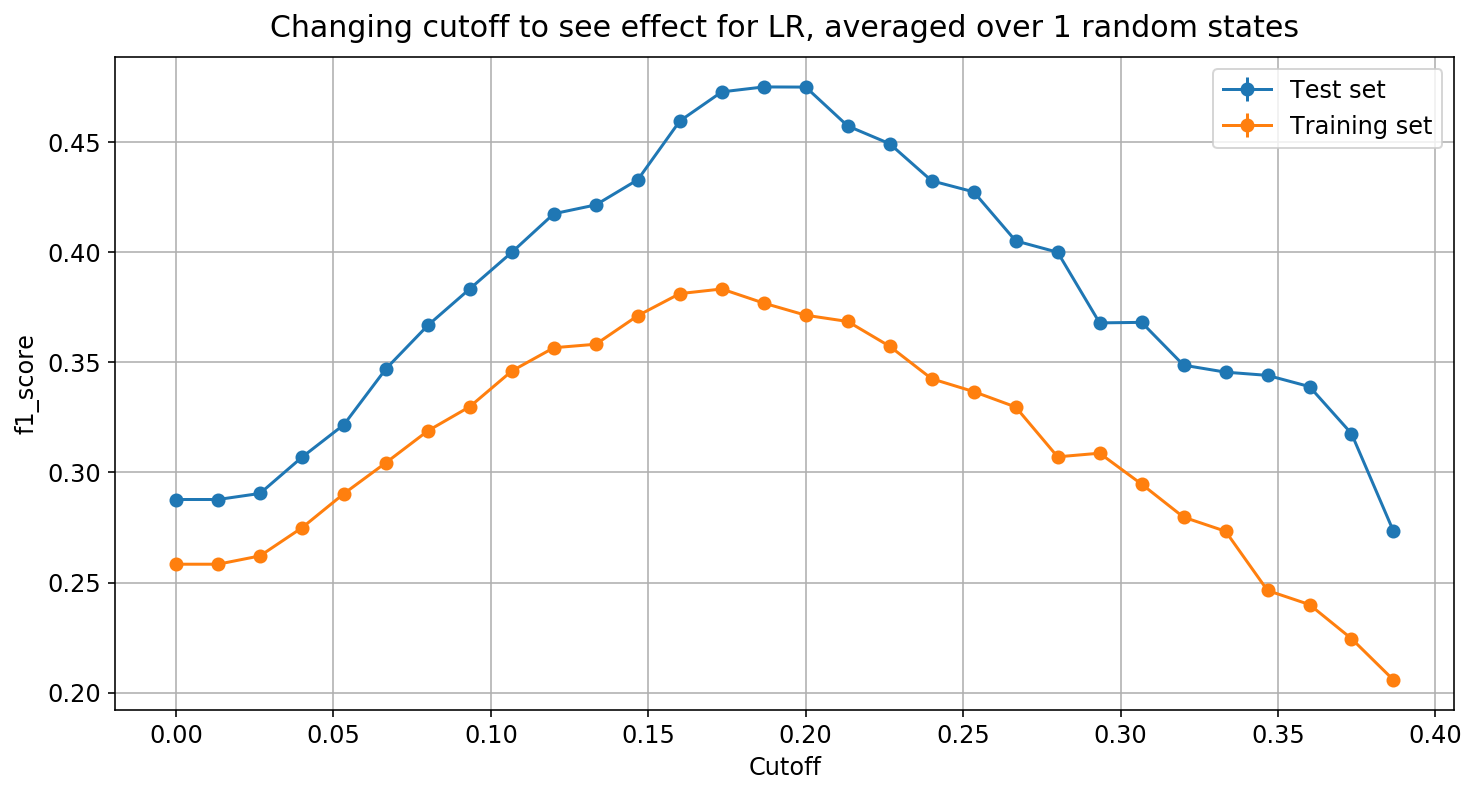

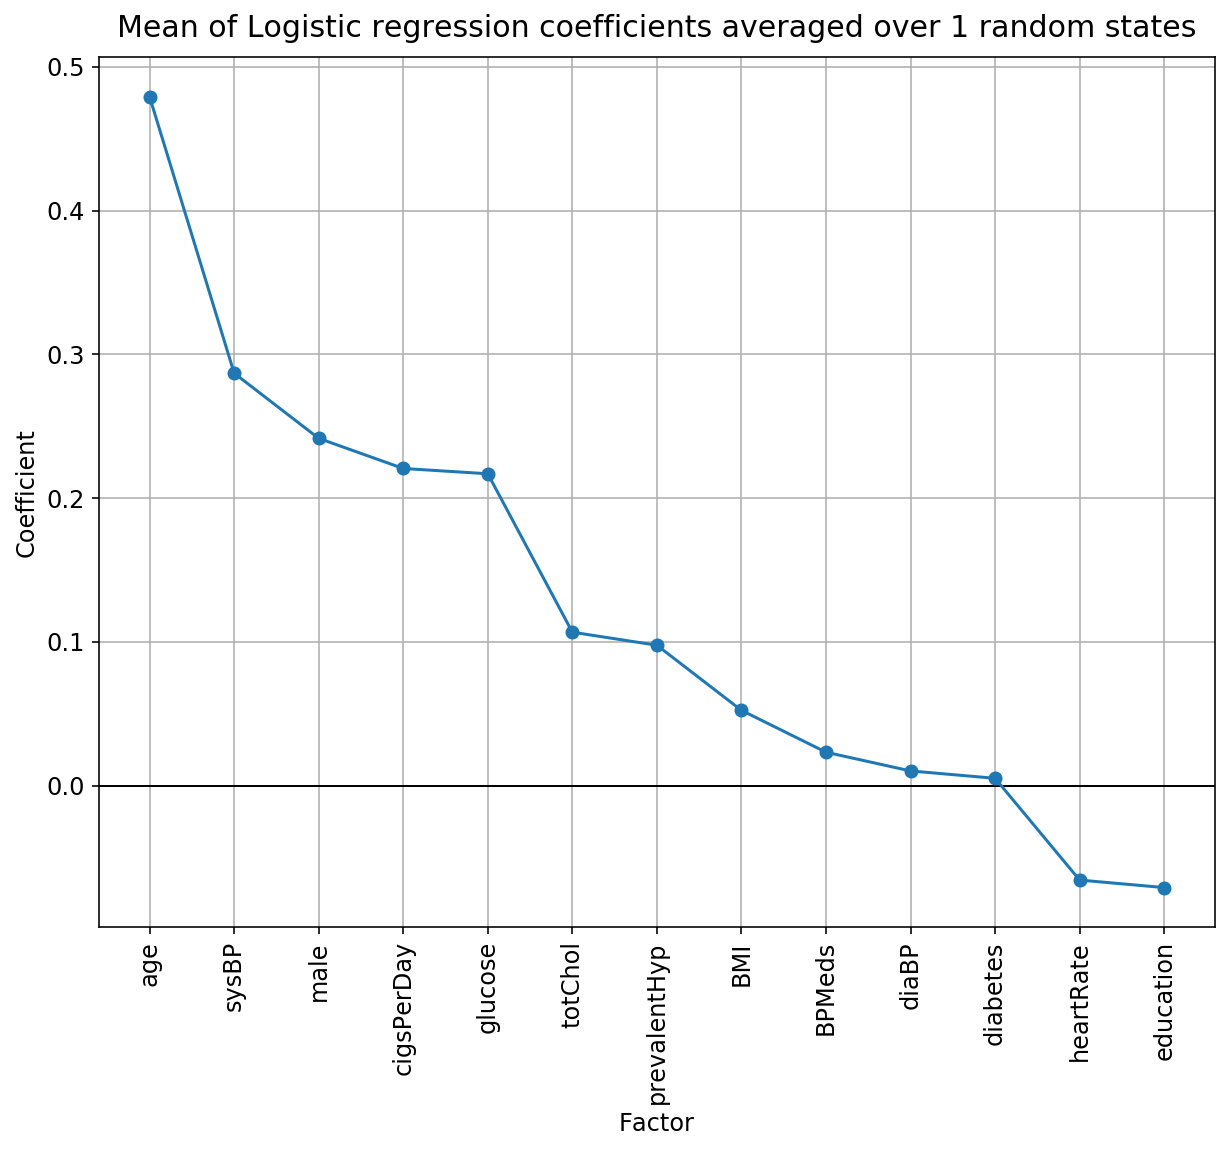

In [85]:
# Check whether overfit using optimal params
n_states = 1
t_cutoff_nstates(dataset_c, algorithms[t_algorithm], n_states=n_states, r_seed=0,
          remove_outliers=optimal_max['remove_outliers'],
          scale='standard', 
          remove_missing = optimal_max['remove_missing'],
          resample = optimal_max['resample'],
          metrics=['f1_score'],x_max=0.4,v=1,op='f1_score',label=t_algorithm)

roc auc for LR: 0.7816492450638792
roc auc for KN: 0.7055615630047927
roc auc for SVM: 0.7833179809630608
roc auc for framingham: 0.6877080249204374


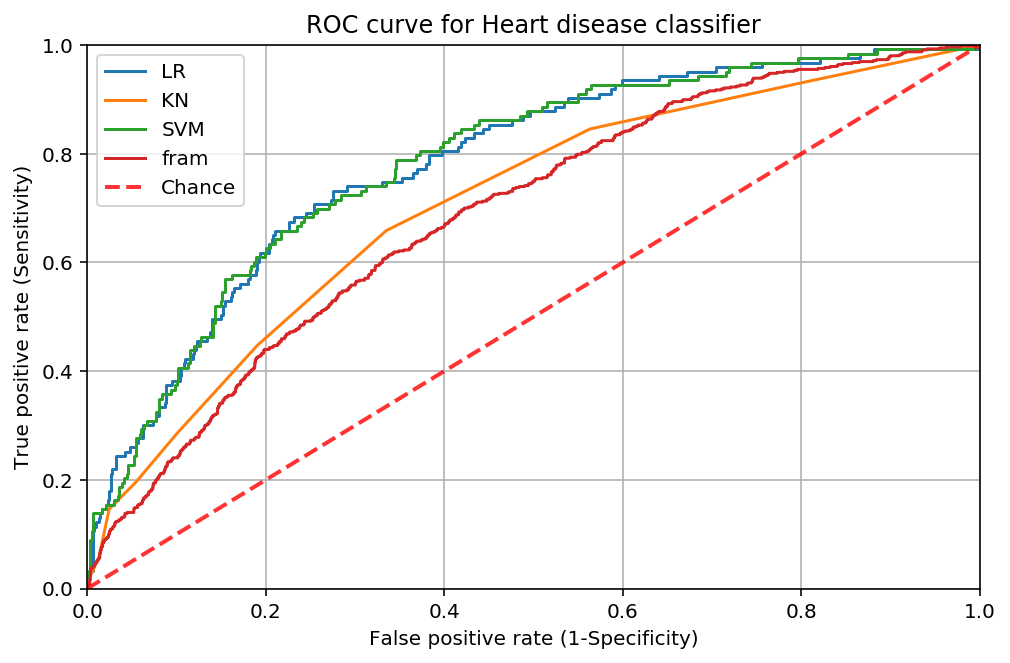

In [38]:
### ROC CURVES

features = ['TenYearCHD','const','sysBP', 'glucose', 'age', 'totChol', 'cigsPerDay', 'diaBP', 'prevalentHyp',
            'diabetes', 'BPMeds', 'male', 'BMI',
            'education', 'heartRate']

features= ['TenYearCHD','const','age', 'sysBP', 'male', 'cigsPerDay', 'glucose', 'totChol', 
                 'prevalentHyp', 'education','heartRate','BMI', 'BPMeds']

dataset_t = pp.chose_features(dataset_c, features=features) # choose n features
dataset_t = pp.drop_missing(dataset_t) # drop missing rows 
dataset_t = pp.scale_data(dataset_t,'standard')
X_train, X_test, y_train, y_test = pp.split_data(dataset_t,r_state=0) # split dataset


##############################################
from sklearn.metrics import roc_curve,roc_auc_score

LR = log_regressor(X_train, y_train) 
KN = k_neighbors(X_train, y_train) 
SVM = support_vector_m(X_train, y_train) 

plt.figure(figsize = (8,5))

y_pred_prob_yes=LR.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_yes[:,1])
plt.plot(fpr,tpr,label ='LR')
print('roc auc for LR:',roc_auc_score(y_test,y_pred_prob_yes[:,1]))

y_pred_prob_yes=KN.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_yes[:,1])
plt.plot(fpr,tpr,label ='KN')
print('roc auc for KN:',roc_auc_score(y_test,y_pred_prob_yes[:,1]))

y_pred_prob_yes=SVM.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_yes[:,1])
plt.plot(fpr,tpr,label ='SVM')
print('roc auc for SVM:',roc_auc_score(y_test,y_pred_prob_yes[:,1]))

fpr, tpr, thresholds = roc_curve(df_fram.TenYearCHD, df_fram.fram_percent)
plt.plot(fpr,tpr,label ='fram')
print('roc auc for framingham:',roc_auc_score(df_fram.TenYearCHD, df_fram.fram_percent))

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.grid(True)
plt.title('ROC curve for Heart disease classifier')
plt.xlabel('False positive rate (1-Specificity)')
plt.ylabel('True positive rate (Sensitivity)')

plt.legend()

In [39]:
### Investigating resampling - I had an idea that we may not have to exactly balance the ratio of CHD 1 and 0 such 
### that it is 1's:0's = 1. It may be adequate to just slightly increase the ratio of 1's:0's from 0.2 to something a bit
### greater without fully balancing. The following code plots the curves....


def t_resampling(dataset,f_algorithm,cutoff=0.5,metric='Accuracy'):
    '''Investigate the effects of resampling and make plots
    - dataset: DataFrame. The dataset to analyse.
    - f_algorithm: function pointer. A function that fits X_train and y_train
    - *cutoff: float in range(0,1). Cutoff by which a positive/negative result is predicted.
    - *metric: string 'Accuracy','Precision','Recall','f1_score'. Score which to return
    '''
    features = ['TenYearCHD','const','sysBP', 'glucose', 'age', 'totChol', 'cigsPerDay', 'diaBP', 'prevalentHyp',
                'diabetes', 'BPMeds', 'male', 'BMI',
                'education', 'heartRate','prevalentStroke'] 

    results = []

    dataset_t = pp.chose_features(dataset, features=features) # choose n features
    dataset_t = pp.drop_missing(dataset_t) # drop missing rows
    dataset_t = pp.scale_data(dataset_t) # scale

    #with resampling
    train, test = pp.split_data(dataset_t,split_dep_var=False) # split into train and test
    X_test, y_test = pp.split_dep_var(test) # Don't mess with the test set!

    range_r = np.arange(0.2, 1.01, 0.05) # range of rations 1:0 

    for ratio in range_r: #
        X_train_up, y_train_up = pp.split_dep_var(pp.upsample(train,ratio_1_to_0=ratio))
        X_train_down, y_train_down = pp.split_dep_var(pp.downsample(train,ratio_1_to_0=ratio))
        X_train_none, y_train_none = pp.split_dep_var(train)

        LR = f_algorithm(X_train_up, y_train_up)
        results_up = performance(LR,X_test,y_test,output= metric,cutoff=cutoff)

        LR = f_algorithm(X_train_down, y_train_down)
        results_down = performance(LR,X_test,y_test,output= metric,cutoff=cutoff)

        LR = f_algorithm(X_train_none, y_train_none)
        results_none = performance(LR,X_test,y_test,output= metric,cutoff=cutoff)


        results.append([results_up,results_down,results_none])

    results = pd.DataFrame(results,columns=['Upsampled','Downsample','Unbalanced'])


    for method in results.columns:
        plt.plot(range_r, results[method],label='{} cutoff: {}'.format(method,cutoff),marker='o')

    plt.grid()
    plt.title('Changing ratio_1_to_0 to see effect on \n{} for resampling methods for {}'.format(metric,str(algorithm)))
    plt.xlabel('ratio_1_to_0')
    plt.ylabel('Score')
    plt.legend(bbox_to_anchor=(1, 0.9))



Upsampled max=0.8443
Downsample max=0.8415
Unbalanced max=0.8415
Upsampled max=0.4734
Downsample max=0.4581
Unbalanced max=0.1714


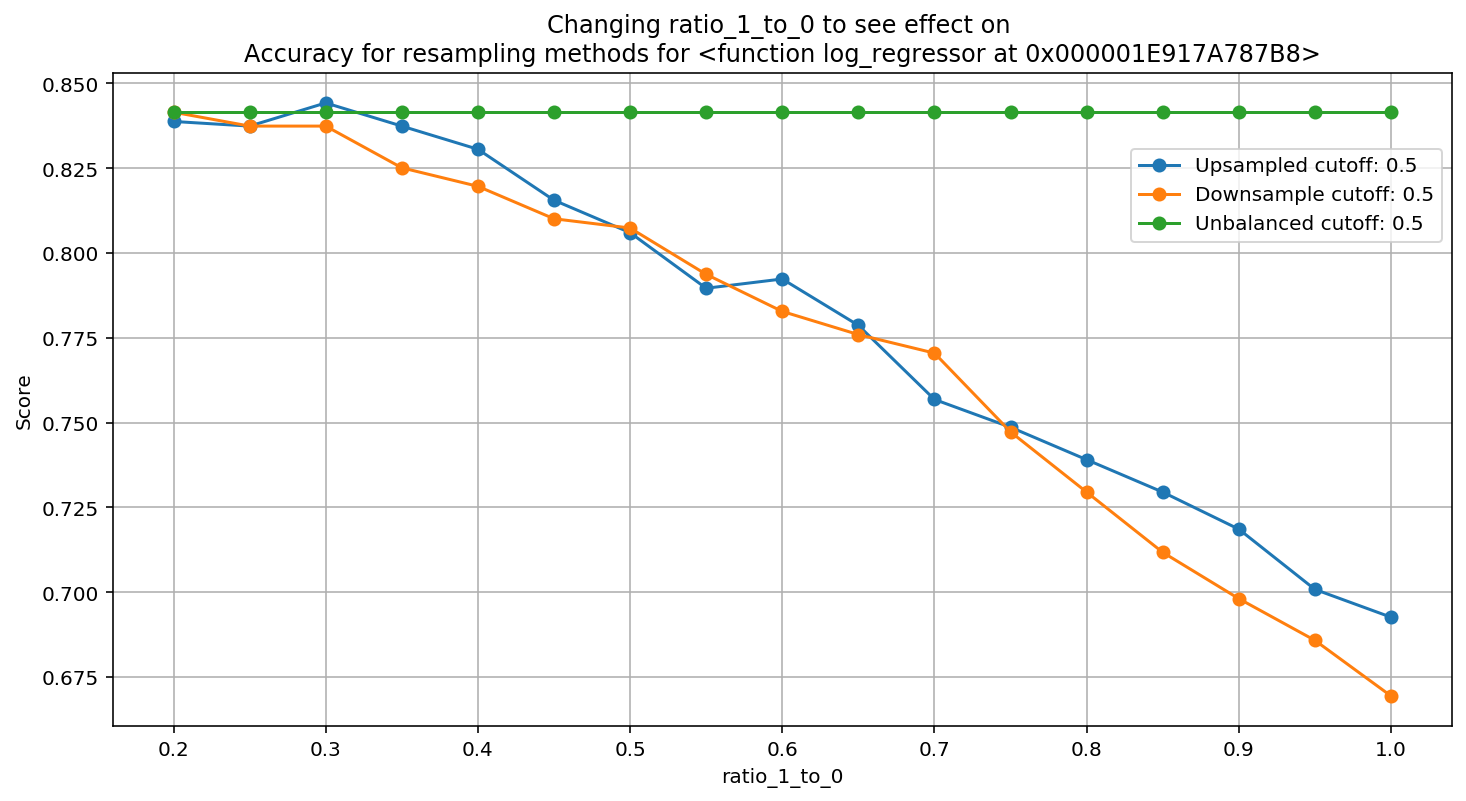

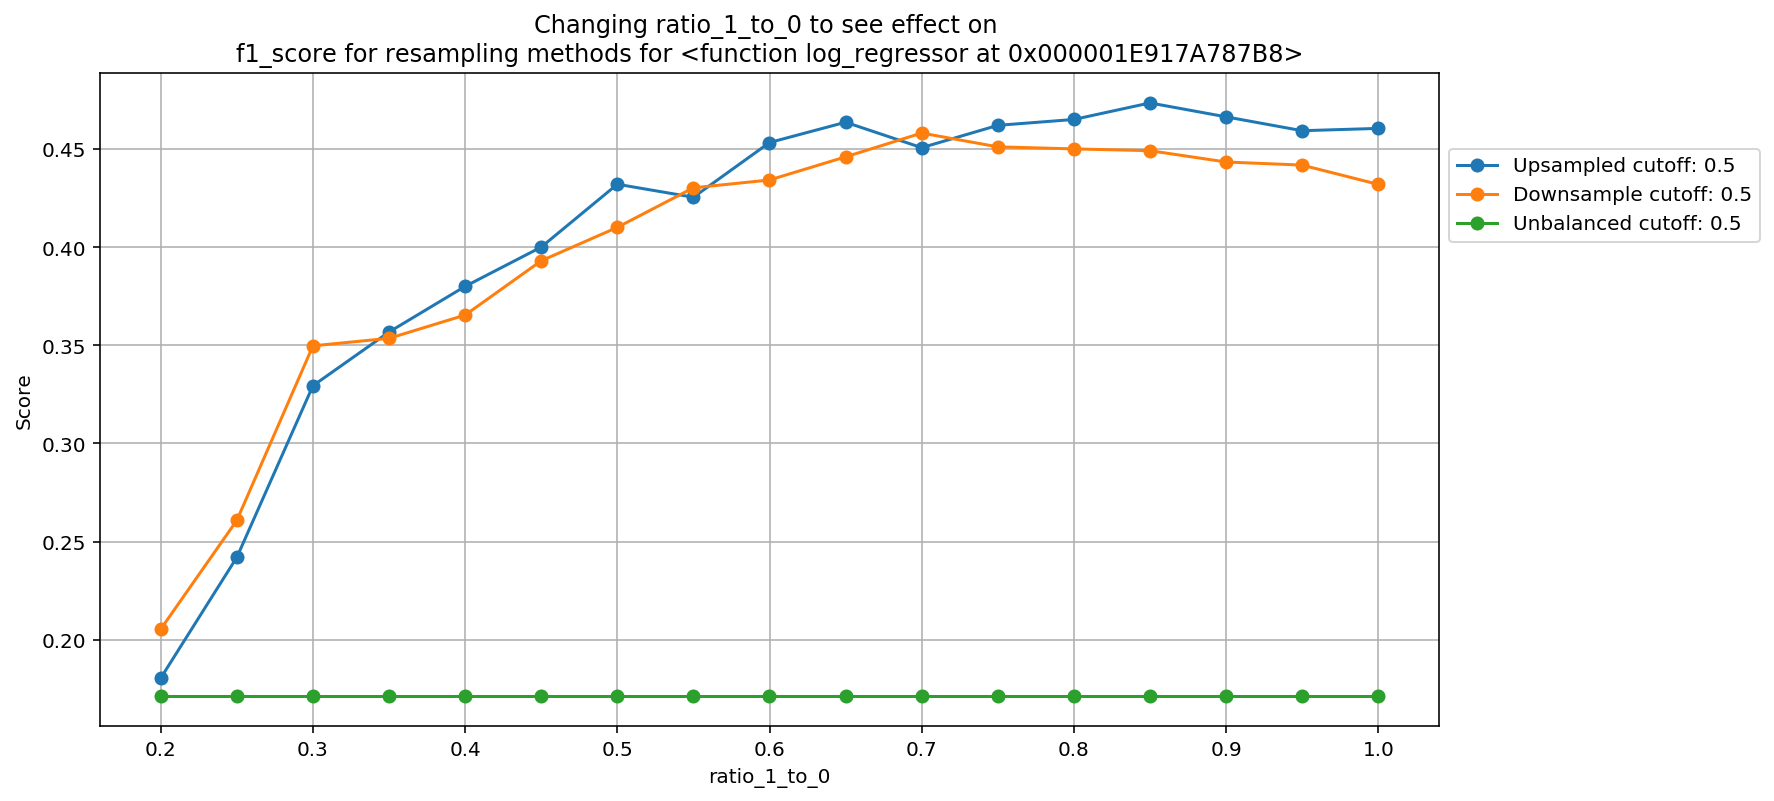

In [297]:
### Running the test function for resampling with LR

plt.figure(figsize=(12, 6))
t_resampling(dataset_c,f_algorithm=log_regressor,metric='Accuracy')

plt.figure(figsize=(12, 6))
t_resampling(dataset_c,f_algorithm=log_regressor,metric='f1_score')


Upsampled max=0.8443
Downsample max=0.8415
Unbalanced max=0.8415
Upsampled max=0.8347
Downsample max=0.8388
Unbalanced max=0.8347
Upsampled max=0.8197
Downsample max=0.8128
Unbalanced max=0.8183
Upsampled max=0.8443
Downsample max=0.8415
Unbalanced max=0.8415
Upsampled max=0.8347
Downsample max=0.8388
Unbalanced max=0.8347
Upsampled max=0.8197
Downsample max=0.8128
Unbalanced max=0.8183
Upsampled max=0.7805
Downsample max=0.7480
Unbalanced max=0.0976
Upsampled max=0.8780
Downsample max=0.8699
Unbalanced max=0.1626
Upsampled max=0.9431
Downsample max=0.9593
Unbalanced max=0.3171


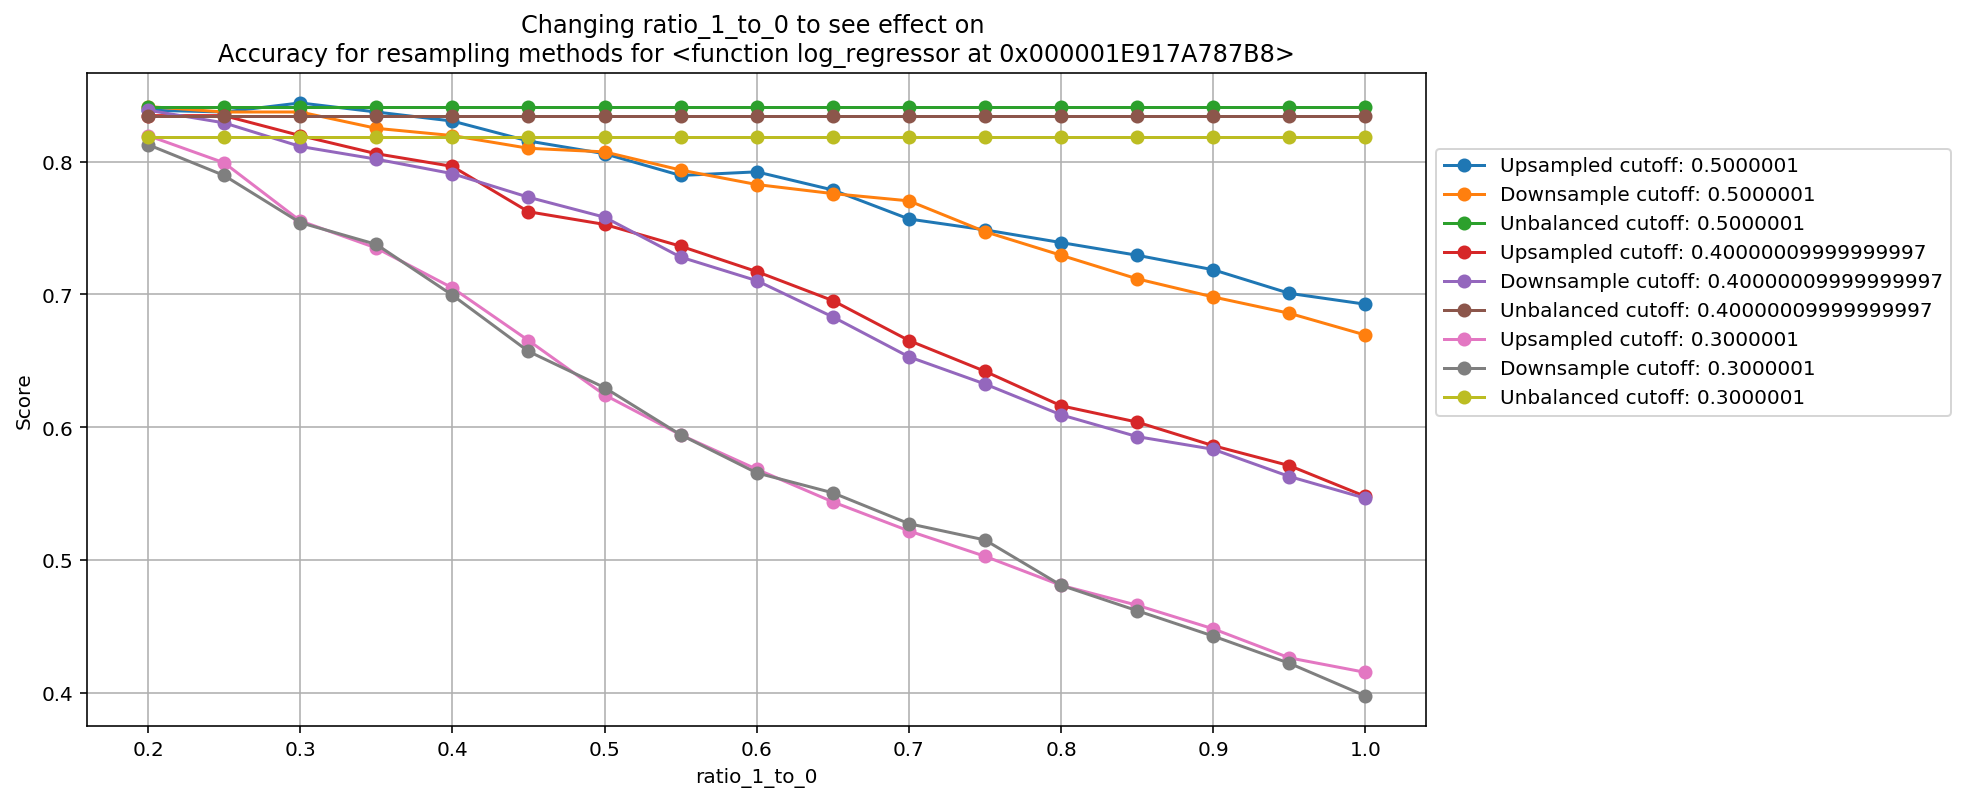

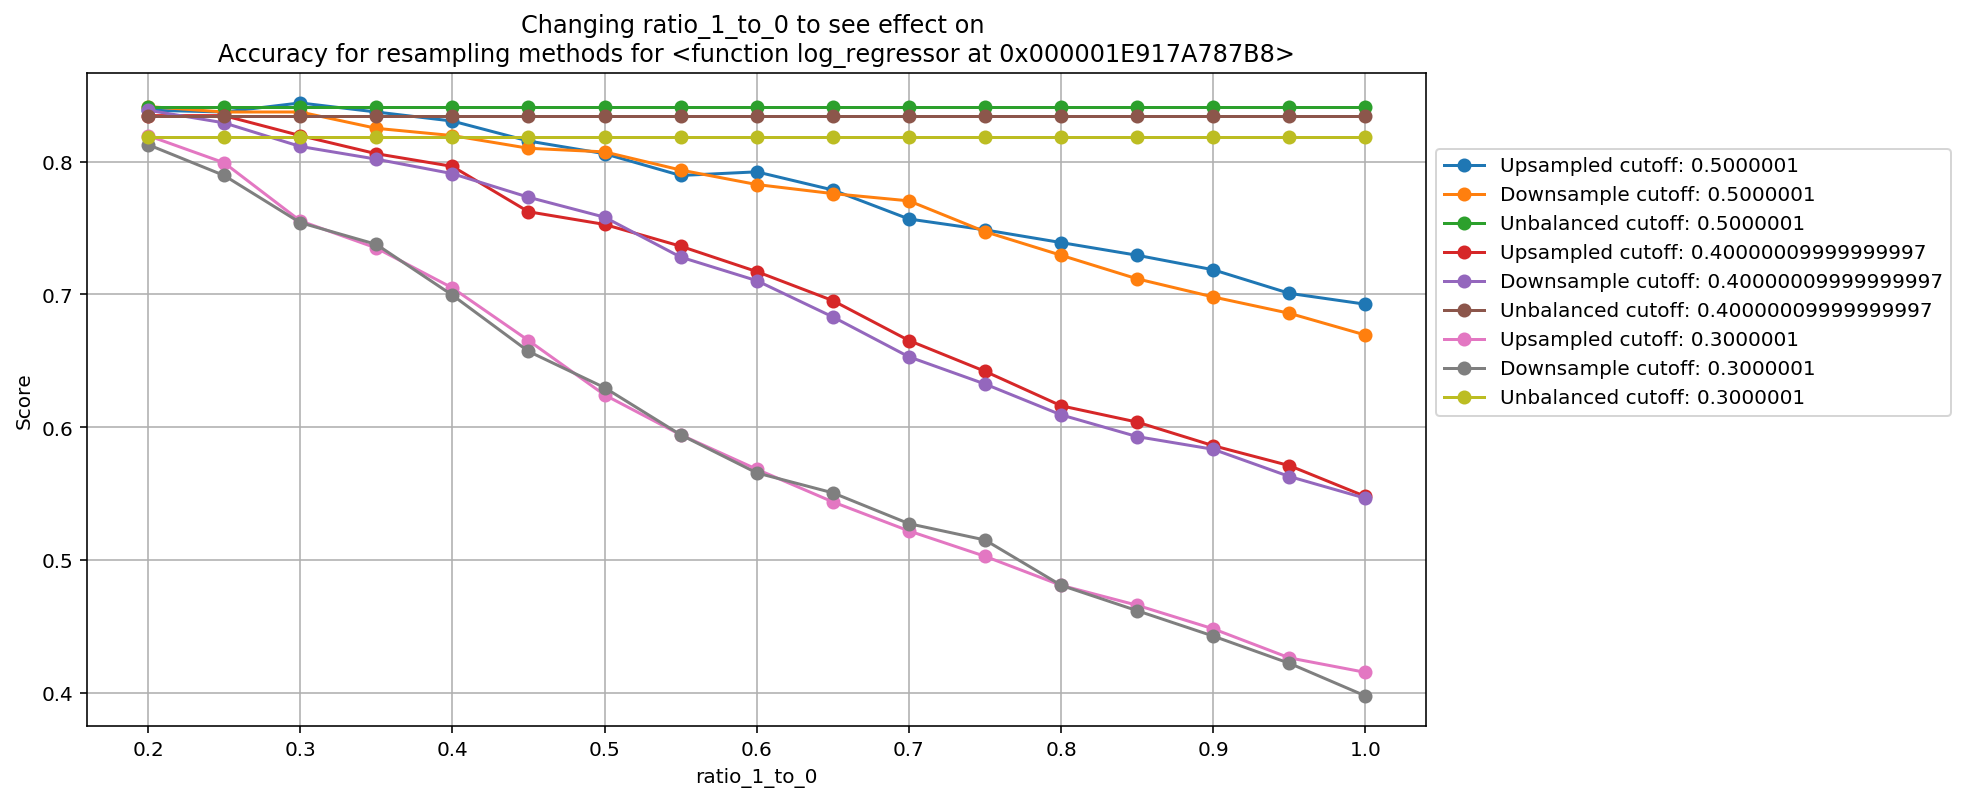

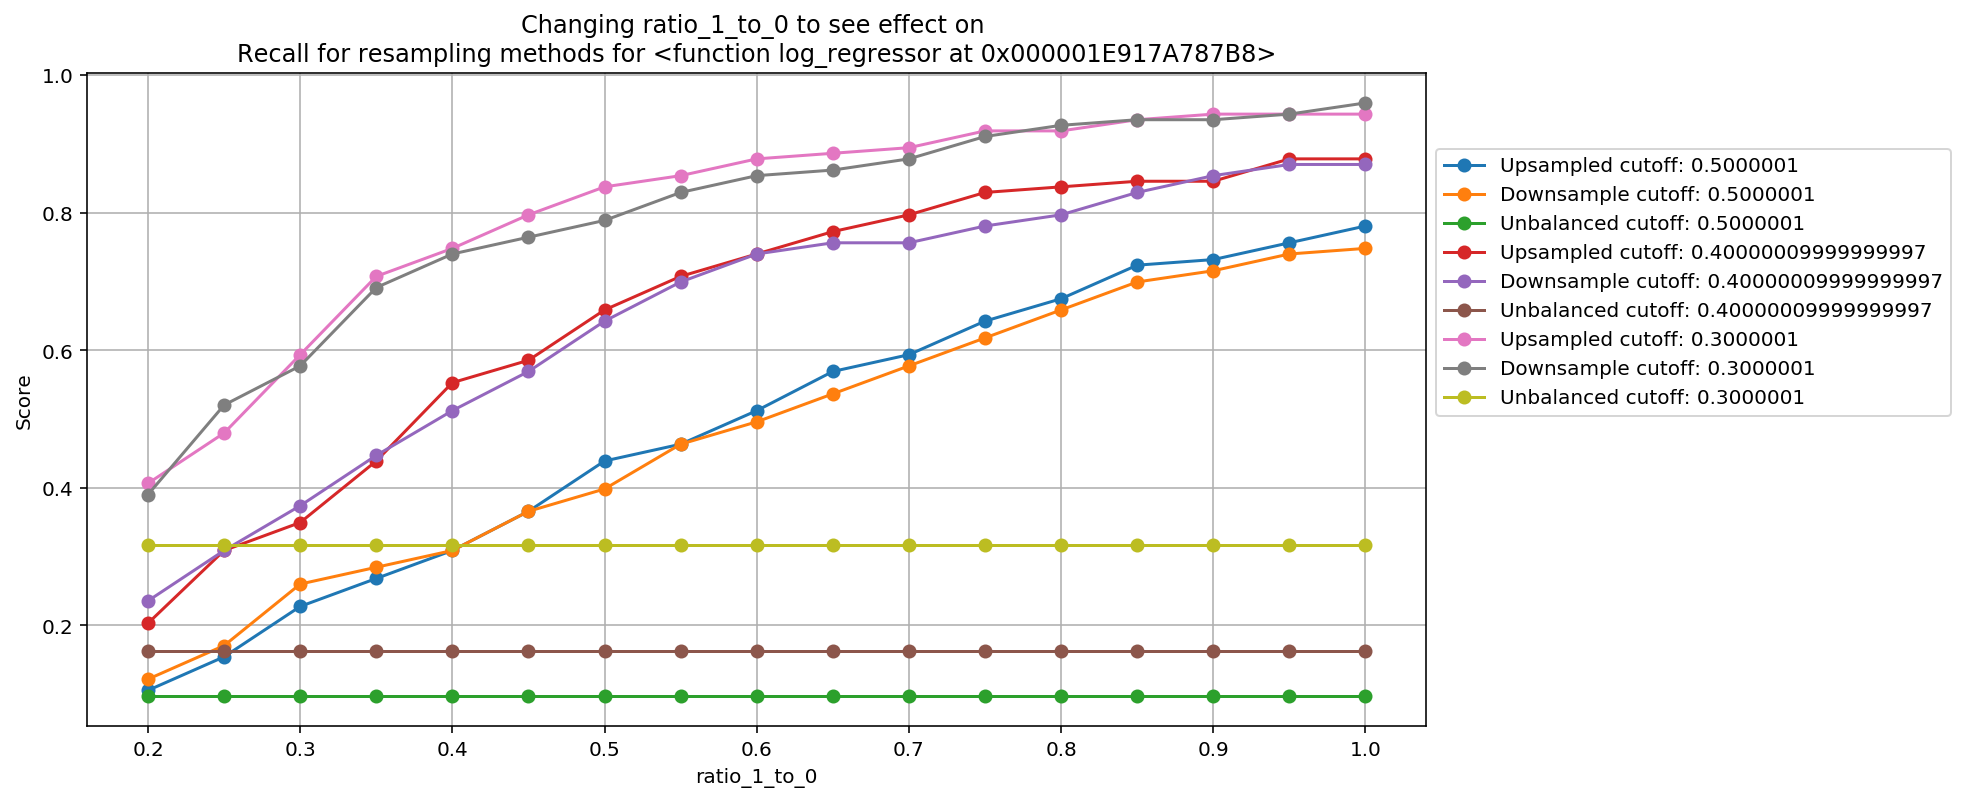

In [301]:
### These graphs are quite confusing but I was interested in the shift when the cutoff was changed

range_cutoff = np.arange(0.5000001, 0.3, -0.1)

plt.figure(figsize=(12, 6))
for cut in range_cutoff:
    t_resampling(dataset_c,f_algorithm=log_regressor,cutoff=cut,metric='Accuracy')

plt.figure(figsize=(12, 6))
for cut in range_cutoff:
    t_resampling(dataset_c,f_algorithm=log_regressor,cutoff=cut,metric='Accuracy')
    
plt.figure(figsize=(12, 6))
for cut in range_cutoff:
    t_resampling(dataset_c,f_algorithm=log_regressor,cutoff=cut,metric='Recall')

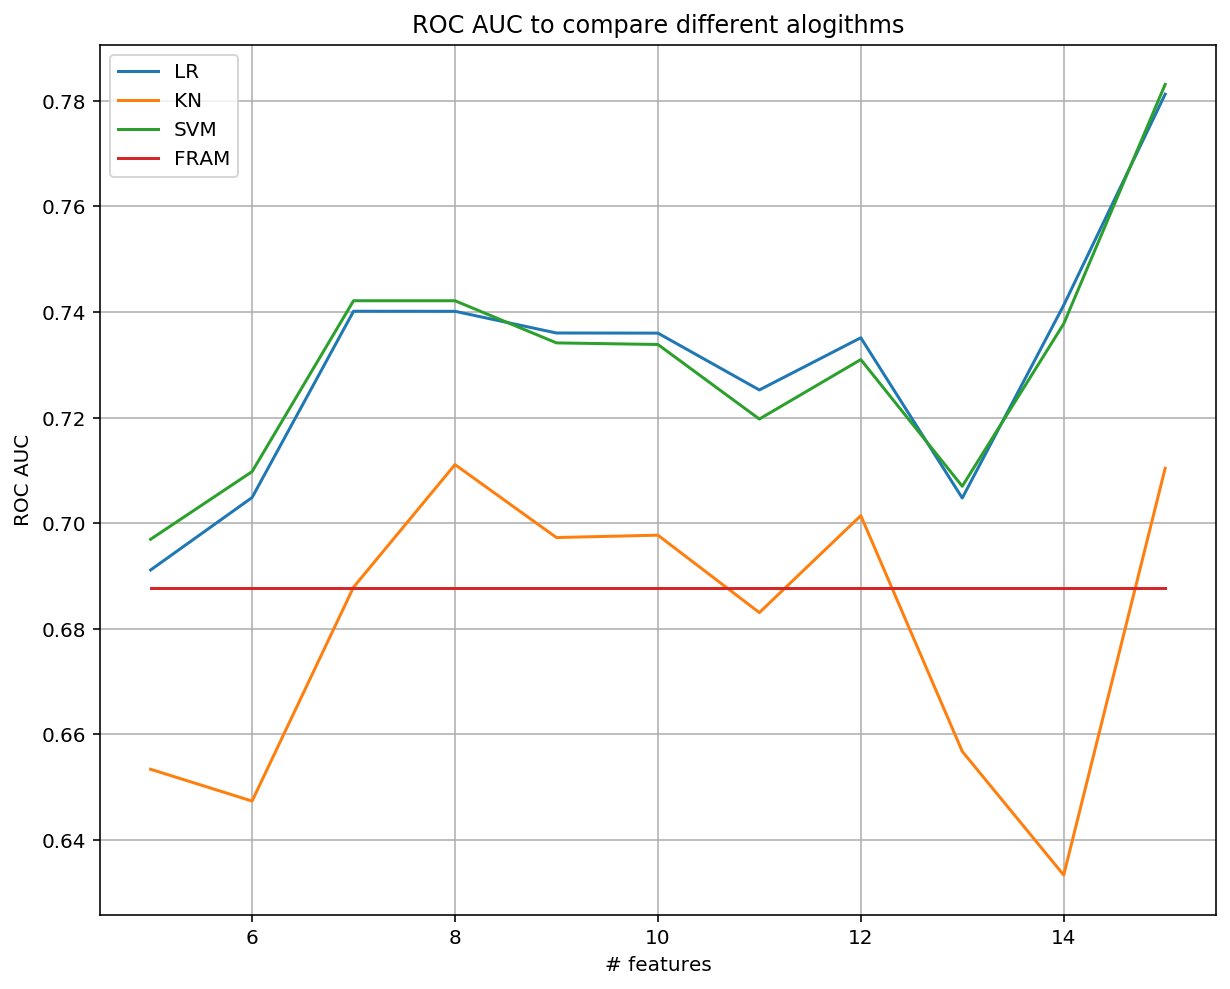

In [314]:
### AUROC for n features
#############################################

roc_auc_df = []
features = ['TenYearCHD','const','sysBP', 'glucose', 'age', 'totChol', 'cigsPerDay', 'diaBP', 'prevalentHyp',
            'diabetes', 'BPMeds', 'male', 'BMI',
            'education', 'heartRate']
import math



for n_features in range(5,len(features)+1):
    dataset_t = pp.chose_features(dataset_c, features=features[:n_features]) # choose n features
    dataset_t = pp.drop_missing(dataset_t) # drop missing rows 
    dataset_t = pp.scale_data(dataset_t)

    X_train, X_test, y_train, y_test = pp.split_data(dataset_t) # split dataset
    LR = log_regressor(X_train, y_train)
    KN = k_neighbors(X_train, y_train)
    SVM = support_vector_m(X_train, y_train)
    row = [0,0,0,0]

    y_pred_prob_yes=LR.predict_proba(X_test)
    row[0] = roc_auc_score(y_test,y_pred_prob_yes[:,1])
  
    y_pred_prob_yes=KN.predict_proba(X_test)
    row[1] = roc_auc_score(y_test,y_pred_prob_yes[:,1])
    
    y_pred_prob_yes=SVM.predict_proba(X_test)
    row[2] = roc_auc_score(y_test,y_pred_prob_yes[:,1])
    
    row[3] = roc_auc_score(df_fram.TenYearCHD, df_fram.fram_percent)
    roc_auc_df.append(row)
    
roc_auc_df=pd.DataFrame(roc_auc_df,columns=['LR','KN','SVM','FRAM'])

plt.figure(figsize=(10,8))
for col in roc_auc_df.columns:
    plt.plot(list(range(5,len(features)+1)),roc_auc_df[col],label=col)
plt.grid(True)
plt.title('ROC AUC to compare different alogithms')
plt.xlabel('# features')
plt.ylabel('ROC AUC')

plt.legend()

0.0 %, 6.25 %, 12.5 %, 18.75 %, 25.0 %, 31.25 %, 37.5 %, 43.75 %, 50.0 %, 56.25 %, 62.5 %, 68.75 %, 75.0 %, LR accuracy max=0.8302
KN accuracy max=0.8090
SVM accuracy max=0.8302
FRAM accuracy max=0.8475


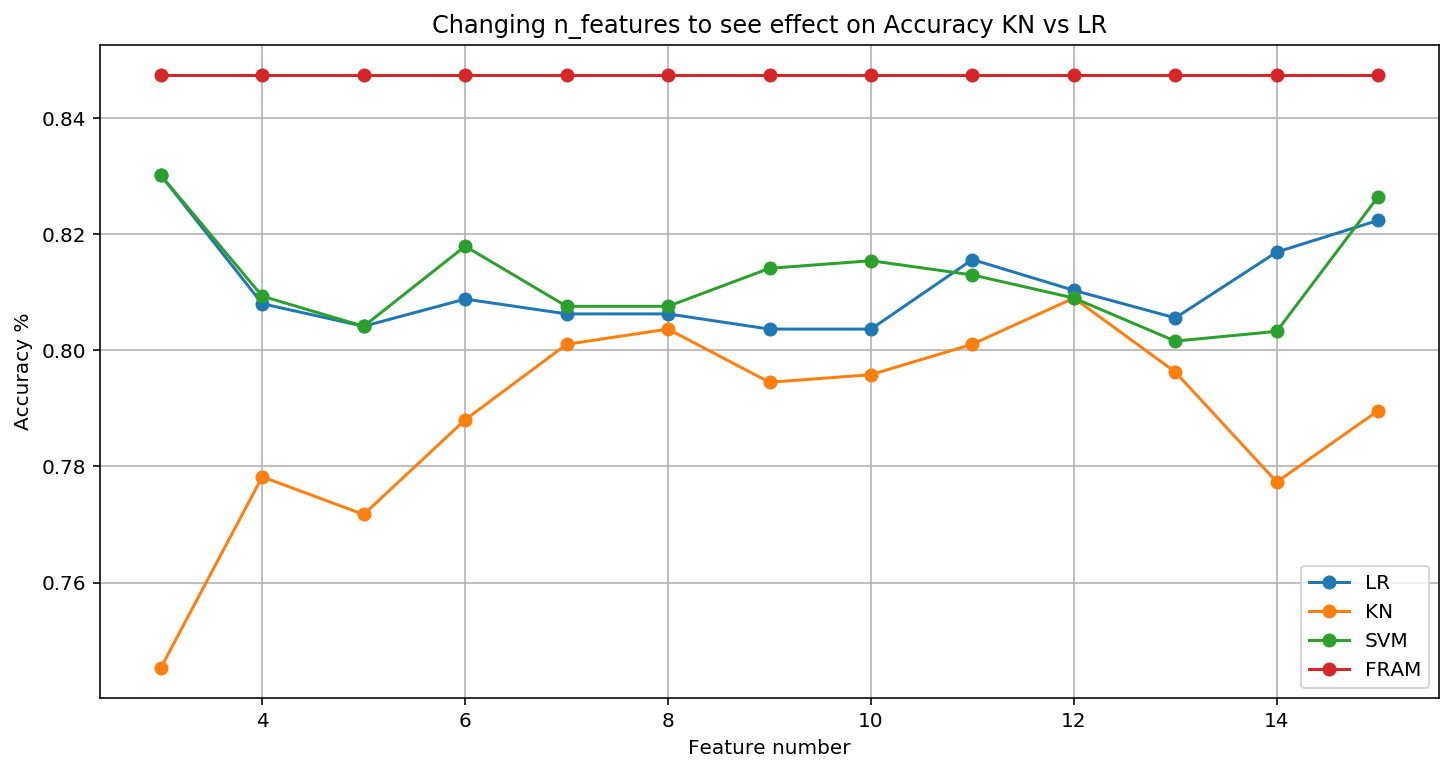

In [302]:
### COMPARE ALGORITHMS AT CONST CUTOFF
###
### - This is MISLEADING as distributions are NOT the same/ symmetric for all algorithms
### - This means that at constant cutoff some algorithms will come out much better. Instead we should OPTIMISE 
###   the cutoff for each algorithm and then plot a similar graph
###


results = []



features = ['TenYearCHD','const','sysBP', 'glucose', 'age', 'totChol', 'cigsPerDay', 'diaBP', 'prevalentHyp',
            'diabetes', 'BPMeds', 'male', 'BMI',
            'education', 'heartRate']

dataset_c = add_constant(dataset)

param = 'Accuracy'
cutoff=0.3

#Investigate effect of no. features
for i in range(3,len(features)+1):
    print((i-3)/(len(features)+1)*100,'%, ',end='')
    dataset_t = pp.chose_features(dataset_c, features=features[:i]) # choose n features

    dataset_t = pp.drop_missing(dataset_t) # drop missing rows



    dataset_t = pp.scale_data(dataset_t)

    
    X_train, X_test, y_train, y_test = pp.split_data(dataset_t) # split dataset
   
    LR = log_regressor(X_train,y_train)
    KN = k_neighbors(X_train,y_train)
    SVM = support_vector_m(X_train,y_train)
    
    
    results.append([performance(LR,X_test,y_test,cutoff=cutoff,output= param),
                    performance(KN,X_test,y_test,cutoff=cutoff,output= param),
                    performance(SVM,X_test,y_test,cutoff=cutoff,output= param),
                    performance('fram',df_fram['fram_percent'],df_fram['TenYearCHD'],cutoff=cutoff,output= param)
                   ])
    
    
    

results = pd.DataFrame(results,columns=['LR','KN','SVM','FRAM'])



plt.figure(figsize=(12, 6))
for algor in results.columns:
    plt.plot(range(3,i+1), results[algor], label=algor,marker='o')
    print(algor, "accuracy max={:.4f}".format(max(results[algor])))

plt.grid()
plt.title('Changing n_features to see effect on {} KN vs LR'.format(param))
plt.xlabel('Feature number')
plt.ylabel('{} %'.format(param))
plt.legend()







Calculating linear regressor...

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
Confusion Matrix:
[[635   3]
 [ 85  11]]
Accuracy: 88.01%
              precision    recall  f1-score   support

           0       0.88      1.00      0.94       638
           1       0.79      0.11      0.20        96

   micro avg       0.88      0.88      0.88       734
   macro avg       0.83      0.55      0.57       734
weighted avg       0.87      0.88      0.84       734



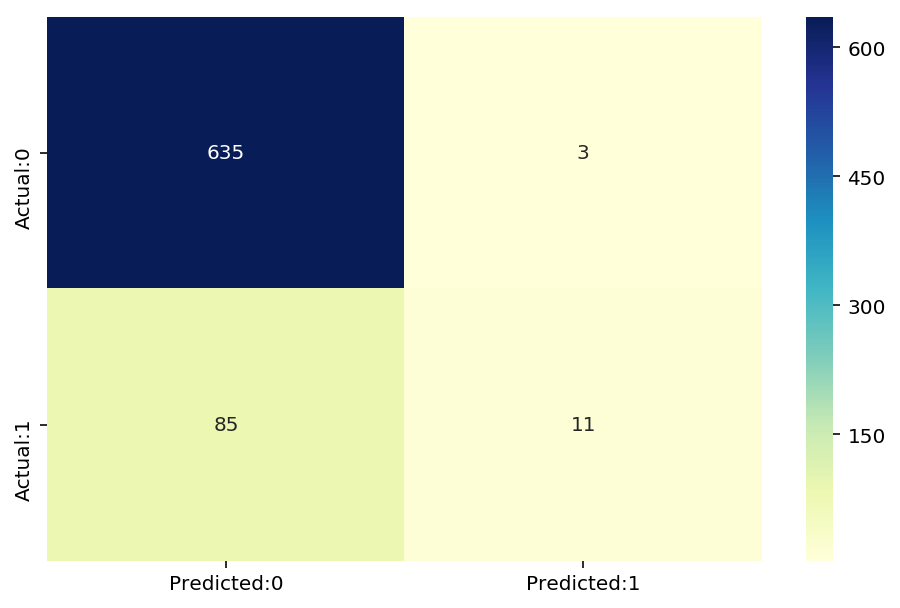

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

print('\nCalculating linear regressor...\n')
LR = LogisticRegression(random_state=0)
LR = LR.fit(X_train, y_train)
print(LR)

y_pred = LR.predict(X_test)

print('Confusion Matrix:')
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sn.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")
print(confusion_matrix(y_test,y_pred))

print('Accuracy: {:.2f}%'.format(accuracy_score(y_test,y_pred)*100))

print(classification_report(y_test,y_pred))



In [ ]:
TN=cm[0,0]
TP=cm[1,1]
FN=cm[1,0]
FP=cm[0,1]
sensitivity=TP/float(TP+FN)
specificity=TN/float(TN+FP)

print('True Positives: {}, True Negatives: {}, False Positives (Type 1 error): {}, False Negatives (Type 2 error): {}\n'
     .format(TP,TN,FP,FN))
    
print('The accuracy of the model = TP+TN/(TP+TN+FP+FN) = ',(TP+TN)/float(TP+TN+FP+FN),'\n',

'The Missclassification = 1-Accuracy = ',1-((TP+TN)/float(TP+TN+FP+FN)),'\n',

'Sensitivity or True Positive Rate = TP/(TP+FN) = ',TP/float(TP+FN),'\n',

'Specificity or True Negative Rate = TN/(TN+FP) = ',TN/float(TN+FP),'\n',

'Positive Predictive value = TP/(TP+FP) = ',TP/float(TP+FP),'\n',

'Negative predictive Value = TN/(TN+FN) = ',TN/float(TN+FN),'\n',

'Positive Likelihood Ratio = Sensitivity/(1-Specificity) = ',sensitivity/(1-specificity),'\n',

'Negative likelihood Ratio = (1-Sensitivity)/Specificity = ',(1-sensitivity)/specificity)


#From the above statistics it is clear that the model is highly specific than sensitive. The negative values are predicted more accurately than the positives.


In [ ]:
from statsmodels.tools import add_constant as add_constant
dataset2 = add_constant(dataset)
dataset2.head()
dataset2 = pp.drop_missing(dataset2)

LR = LogisticRegression(random_state=0)
LR.fit(X_train, y_train) 
cols=dataset2.columns[:-1]
model=sm.Logit(dataset2.TenYearCHD,dataset2[cols])
result=model.fit()
result.summary()

In [ ]:
def back_feature_elem (data_frame,dep_var,col_list):
    """ Takes in the dataframe, the dependent variable and a list of column names, runs the regression repeatedly eleminating feature with the highest
    P-value above alpha one at a time and returns the regression summary with all p-values below alpha"""

    while len(col_list)>0 :
        model=sm.Logit(dep_var,data_frame[col_list])
        result=model.fit(disp=0)
        largest_pvalue=round(result.pvalues,3).nlargest(1)
        if largest_pvalue[0]<(0.05):
            return result
            break
        else:
            col_list=col_list.drop(largest_pvalue.index)

result=back_feature_elem(dataset2,dataset2.TenYearCHD,cols)
result.summary()

In [ ]:
params = np.exp(result.params)
conf = np.exp(result.conf_int())
conf['OR'] = params
pvalue=round(result.pvalues,3)
conf['pvalue']=pvalue
conf.columns = ['CI 95%(2.5%)', 'CI 95%(97.5%)', 'Odds Ratio','pvalue']
print ((conf))

In [ ]:
# dataset2=pp.chose_features(dataset,features=['age','male','cigsPerDay','totChol','sysBP','glucose','TenYearCHD'])
# dataset2=pp.drop_missing(dataset2)
# X_train,X_test,y_train,y_test=pp.split_data(dataset2)

# log_regressor(X_train, X_test, y_train, y_test)
import sklearn
new_features=dataset[['age','male','cigsPerDay','totChol','sysBP','glucose','TenYearCHD']]
new_features=pp.drop_missing(dataset,v=1)
x=new_features.iloc[:,:-1]
y=new_features.iloc[:,-1]

x_train,x_test,y_train,y_test=pp.split_data(new_features,test_size=.20)

from sklearn.linear_model import LogisticRegression
LR=LogisticRegression()
LR.fit(x_train,y_train)
y_pred=LR.predict(x_test)

sklearn.metrics.accuracy_score(y_test,y_pred)

from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sn.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

from sklearn.preprocessing import binarize
for i in range(1,5):
    cm2=0
    y_pred_prob_yes=LR.predict_proba(x_test)
    y_pred2=binarize(y_pred_prob_yes,i/10)[:,1]
    cm2=confusion_matrix(y_test,y_pred2)
    print ('With',i/10,'threshold the Confusion Matrix is ','\n',cm2,'\n',
            'with',cm2[0,0]+cm2[1,1],'correct predictions and',cm2[1,0],'Type II errors( False Negatives)','\n',
          'Sensitivity: ',cm2[1,1]/(float(cm2[1,1]+cm2[1,0])),'Specificity: ',cm2[0,0]/(float(cm2[0,0]+cm2[0,1])),'\n')
    


The following is implemented above

In [ ]:
count=0
for i in dataset.isnull().sum(axis=1):
    if i>0:
        count=count+1
if count>0:
    print(count, 'Rows(or', round((count/len(dataset.index))*100), '%) with missing values are dropped out of total', str(len(dataset.index)))
    dataset.dropna(axis=0,inplace=True)
    print('Now dataset has', len(dataset.index),' rows')

In [ ]:
X = dataset.iloc[:,:-1].values
y = dataset.iloc[:,-1].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [ ]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()

classifier.fit(X_train, y_train)

In [ ]:
y_pred = classifier.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred)
print(cm)

In [ ]:
from sklearn.metrics import accuracy_score as score
print('Accuracy:')
print(score(y_test,y_pred)*100)